# Question-oriented User Exploration
Deep dive into the Mojo's user-related questions and bring as much insights as possible 
Question reference: https://docs.google.com/spreadsheets/d/1U3swTSQ-a8HAKBHeB4dpRx4JrxNchUASkCBwlW9DDY8/edit#gid=7214629


### load python packages, custom-defined functions and set up environment

In [1]:
# load all the packages
import pandas as pd
import numpy as np
import datetime
from IPython.display import display
import os.path
from subscription_donation_preprocess import *
from user_exploration_functions import *
from matplotlib.pyplot import plot
from textwrap import wrap
import itertools
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# to show the whole content in the columns
pd.set_option('display.max_colwidth', -1)

### Filter user files and save the data to new files
- remove the last month of data to avoid bias introduced by incomplete last month data
- remove donation records with paid amount euqal to zero???
- save the filtered data as csv files with suffix '_filtered' added to their original file names.

In [2]:
raw_filenames = ['/home/centos/mojo/data/user_data_v2/MJM_datakind.csv',
                 '/home/centos/mojo/data/user_data_v2/DON_datakind.csv',
                 '/home/centos/mojo/data/user_data_v2/SDN_datakind.csv']

date_column = 'ORD ENTR DT'
amt_column = 'AMT PAID'

for f in raw_filenames:
    
    print("processing " + f)
    if '.csv' in f:
        dat = pd.read_csv(f,encoding = "ISO-8859-1")

    if '.xlsx' in f:
        dat = pd.read_excel(f)
        
    dat[date_column] = pd.to_datetime(dat[date_column])
        
    last_date = datetime.datetime((max(dat[date_column])).year,
                                  (max(dat[date_column])).month,                                     
                                   1)
        
    print("remove data later than " + str(last_date) + ": removed " + str(sum(dat[date_column] >last_date)) + " records")
    dat_filtered = dat[dat[date_column] < last_date]
    
    if 'DON' in f or 'SDN' in f:
        print("remove data with AMT PAID = 0"  + ": removed " + str(sum(dat_filtered[amt_column] <= 0)) + " records")
        dat_filtered = dat_filtered[dat_filtered[amt_column] > 0]

    print("create " + f.replace('.csv','_filtered.csv'))
    dat_filtered.to_csv(f.replace('.csv','_filtered.csv'))
    print('\n')

processing /home/centos/mojo/data/user_data_v2/MJM_datakind.csv
remove data later than 2019-01-01 00:00:00: removed 1823 records
create /home/centos/mojo/data/user_data_v2/MJM_datakind_filtered.csv


processing /home/centos/mojo/data/user_data_v2/DON_datakind.csv
remove data later than 2019-01-01 00:00:00: removed 357 records
remove data with AMT PAID = 0: removed 1016 records
create /home/centos/mojo/data/user_data_v2/DON_datakind_filtered.csv


processing /home/centos/mojo/data/user_data_v2/SDN_datakind.csv
remove data later than 2019-01-01 00:00:00: removed 508 records
remove data with AMT PAID = 0: removed 50 records
create /home/centos/mojo/data/user_data_v2/SDN_datakind_filtered.csv




## load and aggregate data


- load subscription and donation data separately.
- group by email and calculate the frequency, recency, date range and money value of subscriptions and donations
- combine processed subscription and donation data
- Then load pre-processed click data
- group by email and count the unique number of urls and topics the email clicked.
- combine processed subscription and donation data with the aggregated click data to a single wide data frame.


In [2]:
subscription_filenames = ['/home/centos/mojo/data/user_data_v2/MJM_datakind_filtered.csv']
donation_filenames = ['/home/centos/mojo/data/user_data_v2/DON_datakind_filtered.csv',
                      '/home/centos/mojo/data/user_data_v2/SDN_datakind_filtered.csv']

sub_don_combined_filename = '/home/centos/mojo/subscription_donation_processed_data_v2.pkl'
click_data_filename = '/home/centos/mojo/newsletter_processed_data_v2.pkl'
sub_don_click_combined_filename = '/home/centos/mojo/subscription_donation_click_combined_data_v2.pkl'

# load data if its pickle exists otherwise reprocess the data
if os.path.exists(sub_don_combined_filename):
    combined = pd.read_pickle(sub_don_combined_filename)
    subscription_df = []
    for f in subscription_filenames:
        if '.csv' in f:
            dat = pd.read_csv(f,encoding = "ISO-8859-1")
        if '.xlsx' in f:
            dat = pd.read_excel(f)
        subscription_df.append(dat)
    subscription = pd.concat(subscription_df)

    donation_df = []
    for f in donation_filenames:
        if '.csv' in f:
            dat = pd.read_csv(f,encoding = "ISO-8859-1")
        if '.xlsx' in f:
            dat = pd.read_excel(f)
        donation_df.append(dat)
    donation = pd.concat(donation_df)
    print('load the combined processed subscription and donation data as data frame combined')
else:
    subscription, donation, combined = sub_don_process(subscription_filenames,
                                                       donation_filenames,
                                                       column_names = { 'email':'Hashed Email',
                                                                        'amount':'AMT PAID',
                                                                        'date': 'ORD ENTR DT',
                                                                        'pubcode':'PUB'})

    combined.to_pickle(sub_don_combined_filename)
                      
# reformat some columns    
subscription.rename(columns = {'Hashed Email': 'EMAIL', 'PUB':'ORD-PUB-CODE'}, inplace=True)
subscription['ORD ENTR DT'] = pd.to_datetime(subscription['ORD ENTR DT'])

donation.rename(columns = {'Hashed Email': 'EMAIL', 'PUB':'ORD-PUB-CODE'}, inplace=True)
donation['ORD ENTR DT'] = pd.to_datetime(donation['ORD ENTR DT'])

                      
# created by https://github.com/datakind/mj_user_engagement/blob/tingting/newsletter_clicks_parser/mojo_newsletter_clicks_preprocess.py
click_data = pd.read_pickle(click_data_filename)

if os.path.exists(sub_don_click_combined_filename):
    sub_don_click_combined = pd.read_pickle(sub_don_click_combined_filename)
    print('load the combined processed subscription, donation and click data as data frame sub_don_click_combined')

else:    
    nclicks_by_users = click_data.groupby('Email').agg({'Url': pd.Series.nunique,'topic':pd.Series.nunique})
    nclicks_by_users = nclicks_by_users.reset_index()

    nclicks_by_topics = reshape_data_to_wide(click_data,
                                             row = 'Email', 
                                             col = 'topic', 
                                             element = 'Url',
                                             cal = 'sum')
    nclicks_by_topics = nclicks_by_topics.reset_index()
    nclicks_by_topics = nclicks_by_topics.rename(columns = {'':'NA'})

    sub_don_click_combined_temp = combine_dat_sets(combined, 
                                                   nclicks_by_users, 
                                                   'Email','Email', join_method = 'left')
    sub_don_click_combined = combine_dat_sets(sub_don_click_combined_temp, 
                                              nclicks_by_topics, 
                                              'Email','Email', join_method = 'left')
    sub_don_click_combined = sub_don_click_combined.set_index('Email')

    sub_don_click_combined.to_pickle(sub_don_click_combined_filename)

load the combined processed subscription and donation data as data frame combined
load the combined processed subscription, donation and click data as data frame sub_don_click_combined


## Create State Map for donation and subscription
- subset data to only include US data
- aggregate by state and count total amt paid and number of unique emails 

In [3]:
# load state abbr and their 18+ population 
state_population = pd.read_csv('/home/centos/mojo/state_population.csv')
state_population['pct'] = state_population['pop']/sum(state_population['pop'])

# subset donation to only include US data
# aggregate by state and count total amt paid and number of unique emails
# calculate amount pct by state and donor pct by state
# calculate index = donor pct by state / state population pct
df = donation[donation.COUNTRY =='UNITED STATES'].groupby('STATE').agg({'AMT PAID':'sum', 'EMAIL': 'nunique'})
df = df.reset_index()
df['amt_pct'] = df['AMT PAID']/sum(df['AMT PAID'])
df['num_pct'] = df['EMAIL']/sum(df['EMAIL'])
df = df.merge(state_population, left_on='STATE', right_on = 'state')
df['num_index'] = df['num_pct']/df['pct']

# subset subscription to only include US data
# aggregate by state and count total amt paid and number of unique emails
# calculate amount pct by state and subscriber pct by state
# calculate index = subscriber pct by state / state population pct
df2 = subscription[subscription.COUNTRY =='UNITED STATES'].groupby('STATE').agg({'AMT PAID':'sum', 'EMAIL': 'nunique'})
df2 = df2.reset_index()
df2['amt_pct'] = df2['AMT PAID']/sum(df2['AMT PAID'])
df2['num_pct'] = df2['EMAIL']/sum(df2['EMAIL'])
df2 = df2.merge(state_population, left_on='STATE', right_on = 'state')
df2['num_index'] = df2['num_pct']/df2['pct']


In [6]:
amt_US_pct = sum(donation[donation.COUNTRY =='UNITED STATES']['AMT PAID'])/sum(donation['AMT PAID'])
print("""{}% donation are from US""".format(round(amt_US_pct*100,2)))

92.59% donation are from US


In [7]:
US_donors_pct = len(donation[donation.COUNTRY =='UNITED STATES']['EMAIL'].unique())/len(donation['EMAIL'].unique())
print("""{}% donors are from US""".format(round(US_donors_pct*100,2)))

90.74% donors are from US


In [8]:
US_subscribers_pct = len(subscription[subscription.COUNTRY =='UNITED STATES']['EMAIL'].unique())/len(subscription['EMAIL'].unique())
print("""{}% subscribers are from US""".format(round(US_subscribers_pct*100,2)))

94.44% subscribers are from US


### plot Donation Amount by State

In [10]:
fig = plot_statemap( map_title = 'Donation Amount by State (2016-2018)',
                   bar_title = 'Donation $',
                   states = df['STATE'],
                   values = df['AMT PAID']
                 )
py.iplot( fig, filename='d3-cloropleth-map' )

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~holmesaaa/0 or inside your plot.ly account where it is named 'd3-cloropleth-map'


### Plot the number of Donors by State

In [11]:
fig = plot_statemap( map_title = 'The number of Donors by State (2016-2018)',
                   bar_title = '# donors',
                   states = df['STATE'],
                   values = df['EMAIL']
                 )
py.iplot( fig, filename='d3-cloropleth-map' )

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~holmesaaa/0 or inside your plot.ly account where it is named 'd3-cloropleth-map'


### Plot Donor Number Index by state

In [12]:
fig = plot_statemap( map_title = 'Donor Number Index by state (weighted by state 18+ population)(2016-2018)',
                   bar_title = 'donor # index',
                   states = df['STATE'],
                   values = df['num_index']
                 )
py.iplot( fig, filename='d3-cloropleth-map' )

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~holmesaaa/0 or inside your plot.ly account where it is named 'd3-cloropleth-map'


### Plot the number of Subscribers by State

In [14]:
fig = plot_statemap( map_title = 'The number of Subscribers by State (2016-2018)',
                   bar_title = '# subscribers',
                   states = df2['STATE'],
                   values = df2['EMAIL']
                 )
py.iplot( fig, filename='d3-cloropleth-map' )

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~holmesaaa/0 or inside your plot.ly account where it is named 'd3-cloropleth-map'


### plot Subscriber Number Index by state

In [15]:
fig = plot_statemap( map_title = 'Subscriber Number Index by state (weighted by state 18+ population)(2016-2018)',
                   bar_title = 'Subscriber # index',
                   states = df2['STATE'],
                   values = df2['num_index']
                 )
py.iplot( fig, filename='d3-cloropleth-map' )

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~holmesaaa/0 or inside your plot.ly account where it is named 'd3-cloropleth-map'


### The final product of the aggregation process:
data frame 'sub_don_click_combined' with Email as index and columns explained as blow:


|Email| email|
| --- | --- | 
|subs_total|total dollar paid for subscription|
|subs_freq| # subscriptions|
|subs_recency| # days since the latest subscription|
|subs_range| # days between the first and the last subscriptions|
|don_total|total dollar paid for donation|
|don_freq|donations|
|don_recency| # days since the latest donation|
|don_range|# days between the first and the last subscriptions|
|MJM| if the email has pub code MJM |
|DON| if the email has pub code DON |
|SDN| if the email has pub code SDN (recurring donor) |
|process_date| the date when the data is aggregated to calculate the date range |
|topic|	# unique topic the email clicked |
|Url| # unique urls the email clicked | 
|NA| # urls the email clicked for topic 'NA' |	
|DeclineFreeSubscription-Confirmed|	# urls the email clicked for topic 'DeclineFreeSubscription' |
|Russia|# urls the email clicked for topic 'Russia' |
|about|# urls the email clicked for topic 'about' |
|author|# urls the email clicked for topic 'author' |
|authors|# urls the email clicked for topic 'authors' |
|blue-marble|# urls the email clicked for topic 'blue-marble' |
|category|# urls the email clicked for topic 'category' |
|contributor|# urls the email clicked for topic 'contributor' |
|crime-justice|# urls the email clicked for topic 'crime-justice' |
|digitalsample|# urls the email clicked for topic 'digitalsample' |
|environment|# urls the email clicked for topic 'environment' |
|food|# urls the email clicked for topic 'food' |
|kevin-drum|# urls the email clicked for topic 'kevin-drum' |
|media|# urls the email clicked for topic 'media' |
|mediakit|# urls the email clicked for topic 'mediakit' |
|mixed-media|# urls the email clicked for topic 'mixed-media' |
|mojo|# urls the email clicked for topic 'mojo' |
|newsletters|# urls the email clicked for topic 'newsletters' |
|politics|# urls the email clicked for topic 'politics' |
|riff|# urls the email clicked for topic 'riff' |
|thank-you-for-sticking-with-us|# urls the email clicked for topic 'thank-you-for-sticking-with-us' |
|thanks-for-signing-up|# urls the email clicked for topic 'thanks-for-signing-up' |
|tom-philpott|# urls the email clicked for topic 'tom-philpott' |
|topics|# urls the email clicked for topic 'topics' |
|All| # urls the email clicked for all the topics |


## basic summary of the data
- count the number of unique emails by pub code
- calcuate the total amounts by pub code


In [16]:
subscription_counts = basic_counts(subscription)
donation_counts = basic_counts(donation)

subscription_sums = basic_sum(subscription)
donation_sums = basic_sum(donation)


In [17]:
print(subscription_counts)
print(donation_counts)
print(subscription_sums)
print(donation_sums)

{'max_date': Timestamp('2018-12-31 00:00:00'), 'min_date': Timestamp('2016-01-04 00:00:00'), 'nemails': 80660, 'nemails_by_pub':               EMAIL
ORD-PUB-CODE       
MJM           80660, 'noverlap': 0}
{'max_date': Timestamp('2018-12-31 00:00:00'), 'min_date': Timestamp('2016-01-01 00:00:00'), 'nemails': 69424, 'nemails_by_pub':               EMAIL
ORD-PUB-CODE       
DON           62133
SDN           10510, 'noverlap': 3219}
{'max_date': Timestamp('2018-12-31 00:00:00'), 'min_date': Timestamp('2016-01-04 00:00:00'), 'sumamt_by_pub':                 AMT PAID
ORD-PUB-CODE            
MJM           1657196.27, 'sumamt': 1657196.2699998457}
{'max_date': Timestamp('2018-12-31 00:00:00'), 'min_date': Timestamp('2016-01-01 00:00:00'), 'sumamt_by_pub':                 AMT PAID
ORD-PUB-CODE            
DON           5901476.22
SDN           1931331.83, 'sumamt': 7832808.0499999905}


## Create a Pie chart to present the amount distribution

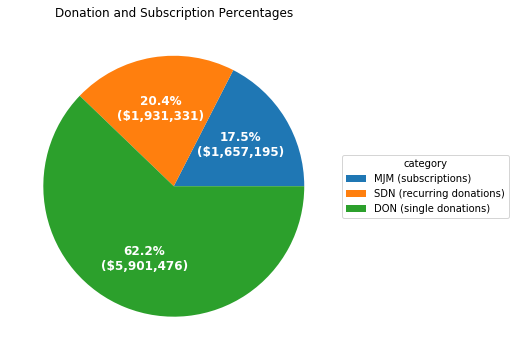

In [18]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(aspect="equal"))

recipe = ["MJM",
          "SDN",
          "DON"]

data = [int(subscription_sums['sumamt_by_pub'].loc['MJM']),
        int(donation_sums['sumamt_by_pub'].loc['SDN']),
        int(donation_sums['sumamt_by_pub'].loc['DON'])]
labels = ['MJM (subscriptions)','SDN (recurring donations)','DON (single donations)']

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n(${:,})".format(pct, absolute)


wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))

ax.legend(wedges, labels,
          title="category",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=12, weight="bold")

ax.set_title("Donation and Subscription Percentages")

plt.show()

## How do the number of subscribers /donors change by year? How do their contribution change by year?

### Use statistical tests to compare donation pre campaign, during campaign and post campaign 

#### group donotion data into spring, fall and dec campaigns
- for each campaign, create three groups:
- donation from the two months prior to the campaign
- donation during the campaign
- donation from the two months after the campaign

In [19]:
don_spring_camp = donation[donation['ORD ENTR DT'].dt.month.isin([5,6])].groupby('EMAIL').agg({'AMT PAID':'sum'})
don_fall_camp = donation[donation['ORD ENTR DT'].dt.month.isin([9,10])].groupby('EMAIL').agg({'AMT PAID':'sum'})
don_dec_camp = donation[donation['ORD ENTR DT'].dt.month.isin([12])].groupby('EMAIL').agg({'AMT PAID':'sum'})

don_pre_spring_camp = donation[donation['ORD ENTR DT'].dt.month.isin([3,4])].groupby('EMAIL').agg({'AMT PAID':'sum'})
don_pre_fall_camp = donation[donation['ORD ENTR DT'].dt.month.isin([7,8])].groupby('EMAIL').agg({'AMT PAID':'sum'})
don_pre_dec_camp = donation[donation['ORD ENTR DT'].dt.month.isin([11])].groupby('EMAIL').agg({'AMT PAID':'sum'})

don_post_spring_camp = donation[donation['ORD ENTR DT'].dt.month.isin([7,8])].groupby('EMAIL').agg({'AMT PAID':'sum'})
don_post_fall_camp = donation[donation['ORD ENTR DT'].dt.month.isin([11])].groupby('EMAIL').agg({'AMT PAID':'sum'})
don_post_dec_camp = donation[donation['ORD ENTR DT'].dt.month.isin([1])].groupby('EMAIL').agg({'AMT PAID':'sum'})


camp = donation[donation['ORD ENTR DT'].dt.month.isin([5,6,9,10,12])].groupby('EMAIL').agg({'AMT PAID':'sum'})
pre_camp = donation[donation['ORD ENTR DT'].dt.month.isin([3,4,7,8,11])].groupby('EMAIL').agg({'AMT PAID':'sum'})
post_camp = donation[donation['ORD ENTR DT'].dt.month.isin([7,8,11,1])].groupby('EMAIL').agg({'AMT PAID':'sum'})

In [133]:
combo_dic = {'period':['pre-campaign']*(don_pre_spring_camp.shape[0] + don_pre_fall_camp.shape[0] + don_pre_dec_camp.shape[0]) + \
                      ['mid-campaign']*(don_spring_camp.shape[0] + don_fall_camp.shape[0] + don_dec_camp.shape[0]) + \
                      ['post-campaign']*(don_post_spring_camp.shape[0] + don_post_fall_camp.shape[0] + don_post_dec_camp.shape[0]),         
             'Donation/Person': pd.concat([don_pre_spring_camp,don_pre_fall_camp,don_pre_dec_camp,
                                           don_spring_camp,don_fall_camp,don_dec_camp,
                                           don_post_spring_camp,don_post_fall_camp,don_post_dec_camp])['AMT PAID'],
             'campaign':['Spring/Summer']*don_pre_spring_camp.shape[0] + ['Fall']*don_pre_fall_camp.shape[0] + ['Dec']*don_pre_dec_camp.shape[0] + \
                        ['Spring/Summer']*don_spring_camp.shape[0] + ['Fall']*don_fall_camp.shape[0] + ['Dec']*don_dec_camp.shape[0] + \
                        ['Spring/Summer']*don_post_spring_camp.shape[0] + ['Fall']*don_post_fall_camp.shape[0] + ['Dec']*don_post_dec_camp.shape[0]
              
            
            
            
            
            }
combo_df = pd.DataFrame.from_dict(combo_dic)

In [134]:
m1 = combo_df.groupby(['period', 'campaign']).agg({'Donation/Person':'sum'})
m1 = m1.reset_index()
m1.rename(columns = {'Donation/Person':'Total Donation'}, inplace=True)
m1 = pd.concat([m1[m1.period == 'pre-campaign'],m1[m1.period == 'mid-campaign'],m1[m1.period == 'post-campaign']])
m1 = m1.sort_values('campaign', ascending = False)

Text(0.5,1,'Campaign Effectiveness on Total Donation')

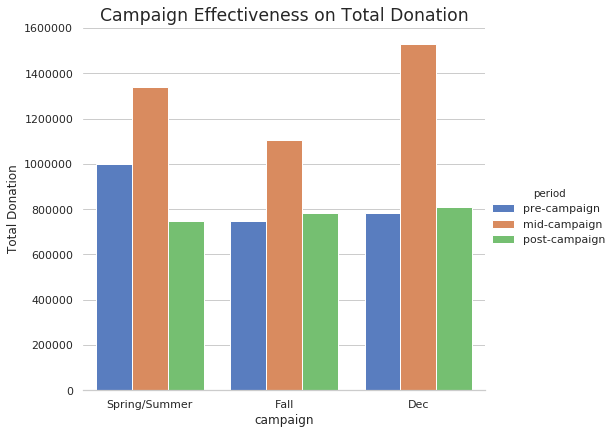

In [135]:
import seaborn as sns
sns.set(style="whitegrid")

# Draw a nested barplot to show survival for class and sex
g = sns.catplot(x="campaign", y="Total Donation", hue="period", data=m1,
                height=6,aspect=1.2, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Total Donation")
plt.title('Campaign Effectiveness on Total Donation', fontsize = 'x-large')

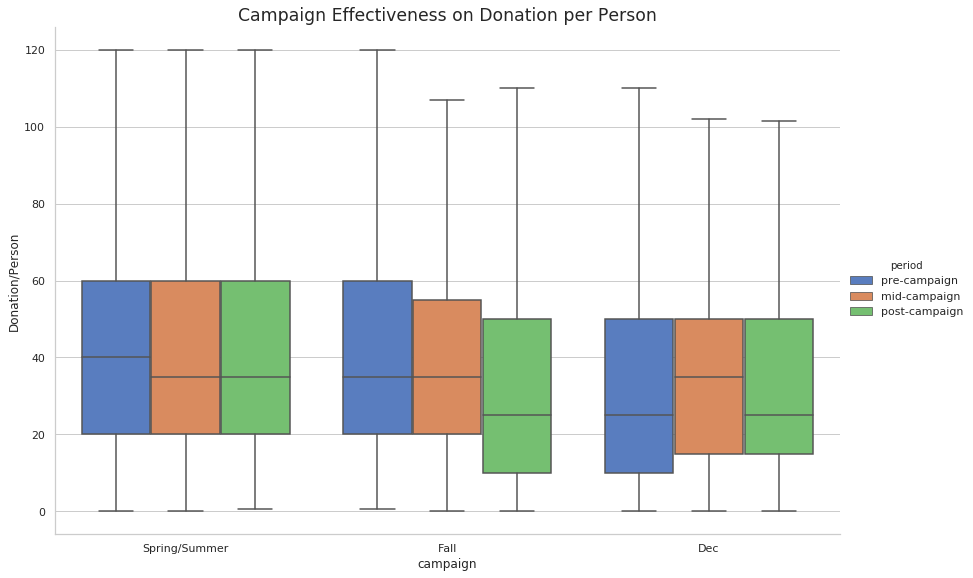

In [136]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
sns.set(style="whitegrid")

testPlot = sns.catplot(x='campaign', y='Donation/Person',
                       hue='period', data=combo_df, palette="muted",
                       showfliers=False,
                       kind='box',height=8, aspect=1.5)

plt.title('Campaign Effectiveness on Donation per Person', fontsize = 'x-large')
m1 = combo_df.groupby(['period', 'campaign'])['Donation/Person'].median().values
mL1 = [str(np.round(s, 2)) for s in m1]





### Conduct T-test and KS test and see if avg donations during campaigns are significant different from these of pre or post campaigns.

In [131]:
from scipy.stats import ks_2samp
from scipy.stats import ttest_ind
import numpy as np

print("\nSpring Campaign test")
x = don_spring_camp['AMT PAID']
y = don_pre_spring_camp['AMT PAID']
z = don_post_spring_camp['AMT PAID']

x = x[x<200]
y = y[y<200]
z = z[z<200]
print(x.mean())
print(y.mean())
print(z.mean())


print(ttest_ind(x,y))
print(ks_2samp(x,y))
print(ttest_ind(x,z))
print(ks_2samp(x,z))

print("\nFall Campaign test")
x = don_fall_camp['AMT PAID']
y = don_pre_fall_camp['AMT PAID']
z = don_post_fall_camp['AMT PAID']

x = x[x<200]
y = y[y<200]
z = z[z<200]
print(x.mean())
print(y.mean())
print(z.mean())

print(ttest_ind(x,y))
print(ks_2samp(x,y))
print(ttest_ind(x,z))
print(ks_2samp(x,z))

print("\nDec Campaign test")
x = don_dec_camp['AMT PAID']
y = don_pre_dec_camp['AMT PAID']
z = don_post_dec_camp['AMT PAID']

x = x[x<200]
y = y[y<200]
z = z[z<200]
print(x.mean())
print(y.mean())
print(z.mean())


print(ttest_ind(x,y))
print(ks_2samp(x,y))
print(ttest_ind(x,z))
print(ks_2samp(x,z))

print("\nOverall Campaign test")
x = camp['AMT PAID']
y = pre_camp['AMT PAID']
z = post_camp['AMT PAID']

x = x[x<200]
y = y[y<200]
z = z[z<200]
print(x.mean())
print(y.mean())
print(z.mean())

print(ttest_ind(x,y))
print(ks_2samp(x,y))
print(ttest_ind(x,z))
print(ks_2samp(x,z))


Spring Campaign test
43.92612043732787
45.08817225779923
42.463863197128674
Ttest_indResult(statistic=-3.372421005442738, pvalue=0.0007458060080282964)
Ks_2sampResult(statistic=0.024846386181030966, pvalue=1.0484119661186387e-05)
Ttest_indResult(statistic=4.134324659800331, pvalue=3.567689830276022e-05)
Ks_2sampResult(statistic=0.03327523452485803, pvalue=4.979326309614167e-09)

Fall Campaign test
41.58057370325697
42.463863197128674
32.21731829573932
Ttest_indResult(statistic=-2.4677346403932017, pvalue=0.013601825867945675)
Ks_2sampResult(statistic=0.03380860763102311, pvalue=6.5009682418294346e-09)
Ttest_indResult(statistic=28.1504157323007, pvalue=1.7851618857588453e-172)
Ks_2sampResult(statistic=0.14467664622161075, pvalue=4.9552621160376e-160)

Dec Campaign test
38.62853340952692
32.21731829573932
34.122473252052735
Ttest_indResult(statistic=20.448014493962763, pvalue=1.878985326944452e-92)
Ks_2sampResult(statistic=0.11759786959046037, pvalue=3.301636990368507e-113)
Ttest_indRes

### aggregate donation data by month and calculate donation bucket pct
- $0 - $24
- $25 - $49
- $50 - $99
- $100 - $199
- $200 - $499
- $500+

In [23]:
unique_years = donation['ORD ENTR DT'].dt.year.unique()
unique_years.sort()
from collections import Counter

donation_pct = {'year_month':[],'0-24':[],'25-49':[],'50-99':[],'100-199':[],'200-499':[],'500+':[]}
for single_year, single_month in itertools.product(unique_years,range(1,13)):

    subset_donation = donation[(donation['ORD ENTR DT'].dt.year == single_year) & \
                               (donation['ORD ENTR DT'].dt.month == single_month)]
    
    buckets = pd.cut(subset_donation['AMT PAID'], 
                     [0, 25, 50, 100 , 200 , 500, 100000], 
                     labels=['0-24','25-49','50-99','100-199','200-499','500+'], 
                     retbins=True, 
                     right=False)
    
    buckets_freq = Counter(buckets[0])
    
    for k in ['0-24','25-49','50-99','100-199','200-499','500+']:
        donation_pct[k].append(buckets_freq[k]/subset_donation.shape[0]*100)
    
    donation_pct['year_month'].append(datetime.datetime(single_year,single_month,1))
donation_pct_df = pd.DataFrame.from_dict(donation_pct)      

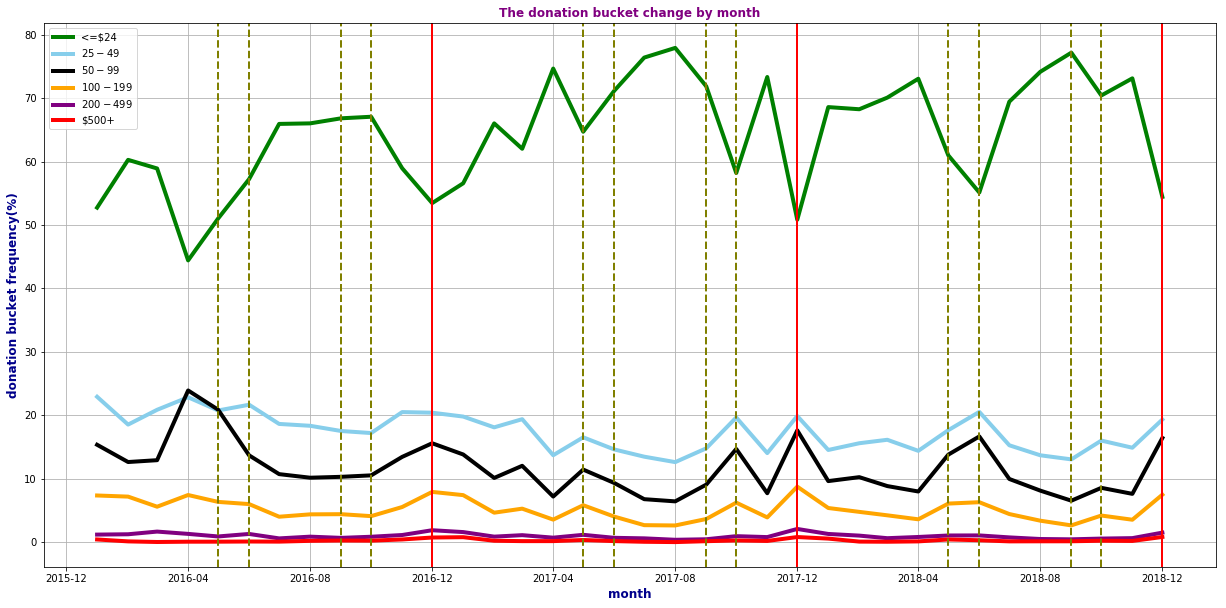

In [24]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [21,10]
plt.plot( 'year_month', '0-24', data=donation_pct_df, marker='', markerfacecolor='green', 
          markersize=12, color='green', linewidth=4)
plt.plot( 'year_month', '25-49',data=donation_pct_df, marker='', color='skyblue', linewidth=4)
plt.plot( 'year_month', '50-99',data=donation_pct_df, marker='', color='black', linewidth=4)
plt.plot( 'year_month', '100-199',data=donation_pct_df, marker='', color='orange', linewidth=4)
plt.plot( 'year_month', '200-499',data=donation_pct_df, marker='', color='purple', linewidth=4)
plt.plot( 'year_month', '500+',data=donation_pct_df, marker='', color='red', linewidth=4)

plt.legend(labels = ['<=$24','$25-$49','$50-$99','$100-$199','$200-$499','$500+'])
plt.grid(True)
plt.title("\n".join(wrap("The donation bucket change by month",50)),fontweight='bold', color = 'purple', fontsize = 'large')
plt.xlabel("month",fontweight='bold', color = 'darkblue', fontsize = 'large')
plt.ylabel("donation bucket frequency(%)",fontweight='bold', color = 'darkblue', fontsize = 'large')
#plt.xticks(counts_by_year_df['year_month'],fontweight='bold', fontsize = 'large')
#pl.yticks(np.arange(0, 101, step=20),fontweight='bold', fontsize = 'large')

for y,m in itertools.product(donation_pct_df.year_month.dt.year.unique(),[5,6,9,10,12]):
    if y != 2019:
        # highlight campaign months
        plt.axvline(x=datetime.datetime(y,m,1), linestyle = '--',color='olive', linewidth=2)

plt.axvline(x=datetime.datetime(2016,12,1), linestyle = '-',color='red', linewidth=2)
plt.axvline(x=datetime.datetime(2017,12,1), linestyle = '-',color='red', linewidth=2)
plt.axvline(x=datetime.datetime(2018,12,1), linestyle = '-',color='red', linewidth=2)

### Aggregate subscription and donation data by month
### make multiple trend plots

In [25]:
unique_years = subscription['ORD ENTR DT'].dt.year.unique()

counts_by_year = {'year_month':[],'MJM':[],'DON':[],'SDN':[]}
for single_year, single_month in itertools.product(unique_years,range(1,13)):
    
    subset_subscription = subscription[(subscription['ORD ENTR DT'].dt.year == single_year) & \
                                       (subscription['ORD ENTR DT'].dt.month == single_month)]
    subset_donation = donation[(donation['ORD ENTR DT'].dt.year == single_year) & \
                               (donation['ORD ENTR DT'].dt.month == single_month)]
    if (not subset_subscription.empty) & (not subset_donation.empty):
        bc_subscription = basic_counts(subset_subscription)
        counts_by_year['MJM'].append(bc_subscription['nemails'])

        bc_donation = basic_counts(subset_donation)
        counts_by_year['SDN'].append(int(bc_donation['nemails_by_pub'].loc['SDN']))
        counts_by_year['DON'].append(int(bc_donation['nemails_by_pub'].loc['DON']))
        
        counts_by_year['year_month'].append(datetime.datetime(single_year,single_month,1))
    
counts_by_year_df = pd.DataFrame.from_dict(counts_by_year)
#counts_by_year_df = counts_by_year_df[counts_by_year_df['year'] != 2019]

events_by_year = {'year_month':[],'MJM':[],'DON':[],'SDN':[]}
for single_year, single_month in itertools.product(unique_years,range(1,13)):
    
    subset_subscription = subscription[(subscription['ORD ENTR DT'].dt.year == single_year) & \
                                       (subscription['ORD ENTR DT'].dt.month == single_month)]
    subset_donation = donation[(donation['ORD ENTR DT'].dt.year == single_year) & \
                               (donation['ORD ENTR DT'].dt.month == single_month)]
    if (not subset_subscription.empty) & (not subset_donation.empty):

        events_by_year['MJM'].append(subset_subscription.shape[0])


        events_by_year['SDN'].append(subset_donation[subset_donation['ORD-PUB-CODE'] =='SDN'].shape[0])
        events_by_year['DON'].append(subset_donation[subset_donation['ORD-PUB-CODE'] =='DON'].shape[0])
        
        events_by_year['year_month'].append(datetime.datetime(single_year,single_month,1))
    
events_by_year_df = pd.DataFrame.from_dict(events_by_year)



amounts_by_year = {'year_month':[],'MJM':[],'DON':[],'SDN':[]}
for single_year, single_month in itertools.product(unique_years,range(1,13)):
    subset_subscription = subscription[(subscription['ORD ENTR DT'].dt.year == single_year) & \
                                       (subscription['ORD ENTR DT'].dt.month == single_month)]
    subset_donation = donation[(donation['ORD ENTR DT'].dt.year == single_year) & \
                               (donation['ORD ENTR DT'].dt.month == single_month)]
                                        
    if (not subset_subscription.empty) & (not subset_donation.empty):
        bc_subscription = basic_sum(subset_subscription)
        amounts_by_year['MJM'].append(bc_subscription['sumamt'])

        bc_donation = basic_sum(subset_donation)
        amounts_by_year['SDN'].append(int(bc_donation['sumamt_by_pub'].loc['SDN']))
        amounts_by_year['DON'].append(int(bc_donation['sumamt_by_pub'].loc['DON']))
        
        amounts_by_year['year_month'].append(datetime.datetime(single_year,single_month,1))

amounts_by_year_df = pd.DataFrame.from_dict(amounts_by_year)
#amounts_by_year_df = amounts_by_year_df[amounts_by_year_df['year'] != 2019]



amounts_unit_by_year = {'year_month':[],'DON':[],'SDN':[]}
for single_year, single_month in itertools.product(unique_years,range(1,13)):

    subset_donation = donation[(donation['ORD ENTR DT'].dt.year == single_year) & \
                               (donation['ORD ENTR DT'].dt.month == single_month)]
                                        
    if not subset_donation.empty:
        total_amounts = basic_sum(subset_donation)
        total_emails = basic_counts(subset_donation)
        amounts_unit_by_year['SDN'].append(int(total_amounts['sumamt_by_pub'].loc['SDN'])/int(total_emails['nemails_by_pub'].loc['SDN']))
        amounts_unit_by_year['DON'].append(int(total_amounts['sumamt_by_pub'].loc['DON'])/int(total_emails['nemails_by_pub'].loc['DON']))
        
        amounts_unit_by_year['year_month'].append(datetime.datetime(single_year,single_month,1))

amounts_unit_by_year_df = pd.DataFrame.from_dict(amounts_unit_by_year)

### plot to show the number of subscribers /donors change by month

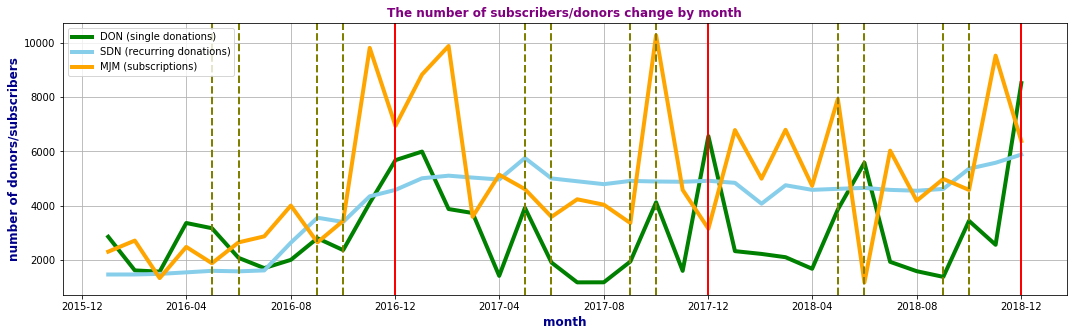

In [26]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18,5]
plt.plot( 'year_month', 'DON', data=counts_by_year_df, marker='', markerfacecolor='green', 
          markersize=12, color='green', linewidth=4)
plt.plot( 'year_month', 'SDN',data=counts_by_year_df, marker='', color='skyblue', linewidth=4)
plt.plot( 'year_month', 'MJM',data=counts_by_year_df, marker='', color='orange', linewidth=4)


plt.legend(labels = ['DON (single donations)','SDN (recurring donations)','MJM (subscriptions)'])
plt.grid(True)
plt.title("\n".join(wrap("The number of subscribers/donors change by month",50)),fontweight='bold', color = 'purple', fontsize = 'large')
plt.xlabel("month",fontweight='bold', color = 'darkblue', fontsize = 'large')
plt.ylabel("number of donors/subscribers",fontweight='bold', color = 'darkblue', fontsize = 'large')
#plt.xticks(counts_by_year_df['year_month'],fontweight='bold', fontsize = 'large')
#pl.yticks(np.arange(0, 101, step=20),fontweight='bold', fontsize = 'large')

for y,m in itertools.product(counts_by_year_df.year_month.dt.year.unique(),[5,6,9,10,12]):
    if y != 2019:
        # highlight campaign months
        plt.axvline(x=datetime.datetime(y,m,1), linestyle = '--',color='olive', linewidth=2)

plt.axvline(x=datetime.datetime(2016,12,1), linestyle = '-',color='red', linewidth=2)
plt.axvline(x=datetime.datetime(2017,12,1), linestyle = '-',color='red', linewidth=2)
plt.axvline(x=datetime.datetime(2018,12,1), linestyle = '-',color='red', linewidth=2)

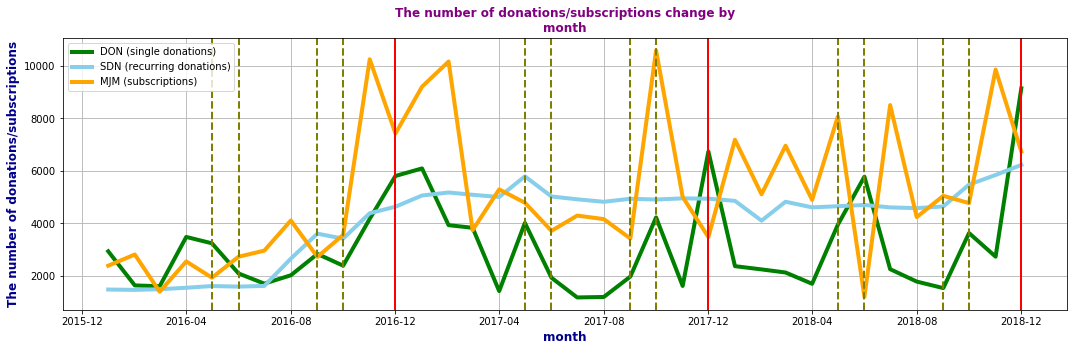

In [27]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18,5]
plt.plot( 'year_month', 'DON', data=events_by_year_df, marker='', markerfacecolor='green', 
          markersize=12, color='green', linewidth=4)
plt.plot( 'year_month', 'SDN',data=events_by_year_df, marker='', color='skyblue', linewidth=4)
plt.plot( 'year_month', 'MJM',data=events_by_year_df, marker='', color='orange', linewidth=4)


plt.legend(labels = ['DON (single donations)','SDN (recurring donations)','MJM (subscriptions)'])
plt.grid(True)
plt.title("\n".join(wrap("The number of donations/subscriptions change by month",50)),fontweight='bold', color = 'purple', fontsize = 'large')
plt.xlabel("month",fontweight='bold', color = 'darkblue', fontsize = 'large')
plt.ylabel("The number of donations/subscriptions",fontweight='bold', color = 'darkblue', fontsize = 'large')
#plt.xticks(counts_by_year_df['year_month'],fontweight='bold', fontsize = 'large')
#pl.yticks(np.arange(0, 101, step=20),fontweight='bold', fontsize = 'large')

for y,m in itertools.product(counts_by_year_df.year_month.dt.year.unique(),[5,6,9,10,12]):
    if y != 2019:
        # highlight campaign months
        plt.axvline(x=datetime.datetime(y,m,1), linestyle = '--',color='olive', linewidth=2)

plt.axvline(x=datetime.datetime(2016,12,1), linestyle = '-',color='red', linewidth=2)
plt.axvline(x=datetime.datetime(2017,12,1), linestyle = '-',color='red', linewidth=2)
plt.axvline(x=datetime.datetime(2018,12,1), linestyle = '-',color='red', linewidth=2)

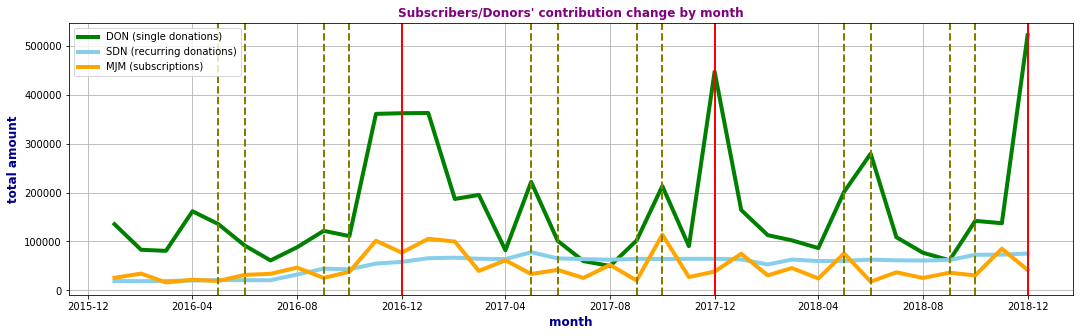

In [28]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [18,5]
plt.plot( 'year_month', 'DON', data=amounts_by_year_df, marker='', markerfacecolor='green', 
          markersize=12, color='green', linewidth=4)
plt.plot( 'year_month', 'SDN',data=amounts_by_year_df, marker='', color='skyblue', linewidth=4)
plt.plot( 'year_month', 'MJM',data=amounts_by_year_df, marker='', color='orange', linewidth=4)


plt.legend(labels = ['DON (single donations)','SDN (recurring donations)','MJM (subscriptions)'])
plt.grid(True)
plt.title("\n".join(wrap("Subscribers/Donors' contribution change by month",50)),fontweight='bold', color = 'purple', fontsize = 'large')
plt.xlabel("month",fontweight='bold', color = 'darkblue', fontsize = 'large')
plt.ylabel("total amount",fontweight='bold', color = 'darkblue', fontsize = 'large')
#plt.xticks(counts_by_year_df['year'],fontweight='bold', fontsize = 'large')


for y,m in itertools.product(counts_by_year_df.year_month.dt.year.unique(),[5,6,9,10,12]):
    if y != 2019:
        # highlight campaign months
        plt.axvline(x=datetime.datetime(y,m,1), linestyle = '--',color='olive', linewidth=2)

plt.axvline(x=datetime.datetime(2016,12,1), linestyle = '-',color='red', linewidth=2)
plt.axvline(x=datetime.datetime(2017,12,1), linestyle = '-',color='red', linewidth=2)
plt.axvline(x=datetime.datetime(2018,12,1), linestyle = '-',color='red', linewidth=2)

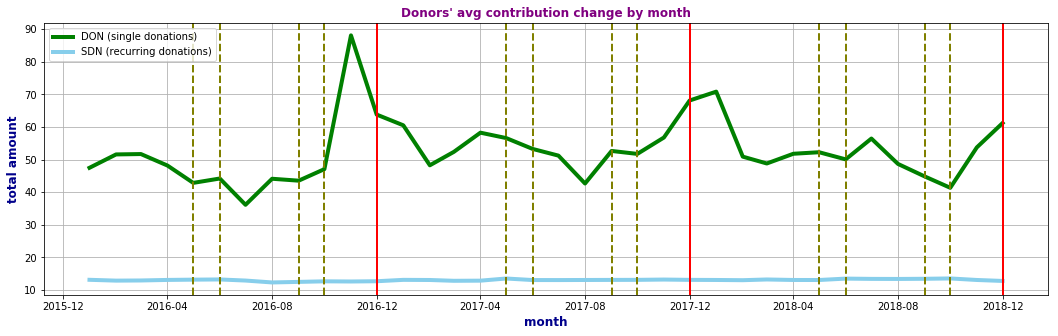

In [29]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [18,5]
plt.plot( 'year_month', 'DON', data=amounts_unit_by_year_df, marker='', markerfacecolor='green', 
          markersize=12, color='green', linewidth=4)
plt.plot( 'year_month', 'SDN',data=amounts_unit_by_year_df, marker='', color='skyblue', linewidth=4)


plt.legend(labels = ['DON (single donations)','SDN (recurring donations)'])
plt.grid(True)
plt.title("\n".join(wrap("Donors' avg contribution change by month",50)),fontweight='bold', color = 'purple', fontsize = 'large')
plt.xlabel("month",fontweight='bold', color = 'darkblue', fontsize = 'large')
plt.ylabel("total amount",fontweight='bold', color = 'darkblue', fontsize = 'large')
#plt.xticks(counts_by_year_df['year'],fontweight='bold', fontsize = 'large')


for y,m in itertools.product(counts_by_year_df.year_month.dt.year.unique(),[5,6,9,10,12]):
    if y != 2019:
        # highlight campaign months
        plt.axvline(x=datetime.datetime(y,m,1), linestyle = '--',color='olive', linewidth=2)

plt.axvline(x=datetime.datetime(2016,12,1), linestyle = '-',color='red', linewidth=2)
plt.axvline(x=datetime.datetime(2017,12,1), linestyle = '-',color='red', linewidth=2)
plt.axvline(x=datetime.datetime(2018,12,1), linestyle = '-',color='red', linewidth=2)

### aggregate click data by month and make trend plot

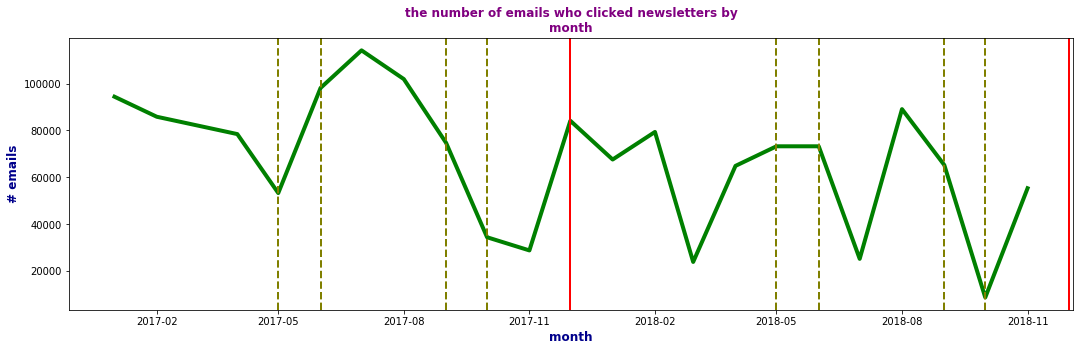

In [30]:
import itertools
nemails_by_month = click_data.groupby('file_month').agg({'Email':'nunique'})
nemails_by_month = nemails_by_month.reset_index()
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [18,5]
plt.plot( 'file_month', 'Email', data=nemails_by_month, marker='', markerfacecolor='green', 
          markersize=12, color='green', linewidth=4)



plt.title("\n".join(wrap("the number of emails who clicked newsletters by month",50)),fontweight='bold', color = 'purple', fontsize = 'large')
plt.xlabel("month",fontweight='bold', color = 'darkblue', fontsize = 'large')
plt.ylabel("# emails",fontweight='bold', color = 'darkblue', fontsize = 'large')
#plt.xticks(counts_by_year_df['year'],fontweight='bold', fontsize = 'large')

for y,m in itertools.product([2017,2018],[5,6,9,10,12]):
    if y != 2019:
        # highlight campaign months
        plt.axvline(x=datetime.datetime(y,m,1), linestyle = '--',color='olive', linewidth=2)


plt.axvline(x=datetime.datetime(2017,12,1), linestyle = '-',color='red', linewidth=2)
plt.axvline(x=datetime.datetime(2018,12,1), linestyle = '-',color='red', linewidth=2)

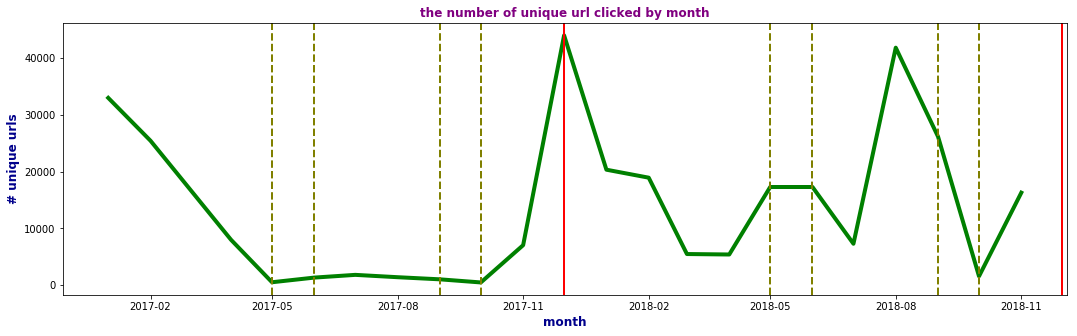

In [32]:
nurls_by_month = click_data.groupby('file_month').agg({'Url':'nunique'})

nurls_by_month = nurls_by_month.reset_index()
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [18,5]
plt.plot( 'file_month', 'Url', data=nurls_by_month, marker='', markerfacecolor='green', 
          markersize=12, color='green', linewidth=4)



plt.title("\n".join(wrap("the number of unique url clicked by month",50)),fontweight='bold', color = 'purple', fontsize = 'large')
plt.xlabel("month",fontweight='bold', color = 'darkblue', fontsize = 'large')
plt.ylabel("# unique urls",fontweight='bold', color = 'darkblue', fontsize = 'large')
#plt.xticks(counts_by_year_df['year'],fontweight='bold', fontsize = 'large')

for y,m in itertools.product([2017,2018],[5,6,9,10,12]):
    if y != 2019:
        # highlight campaign months
        plt.axvline(x=datetime.datetime(y,m,1), linestyle = '--',color='olive', linewidth=2)


plt.axvline(x=datetime.datetime(2017,12,1), linestyle = '-',color='red', linewidth=2)
plt.axvline(x=datetime.datetime(2018,12,1), linestyle = '-',color='red', linewidth=2)

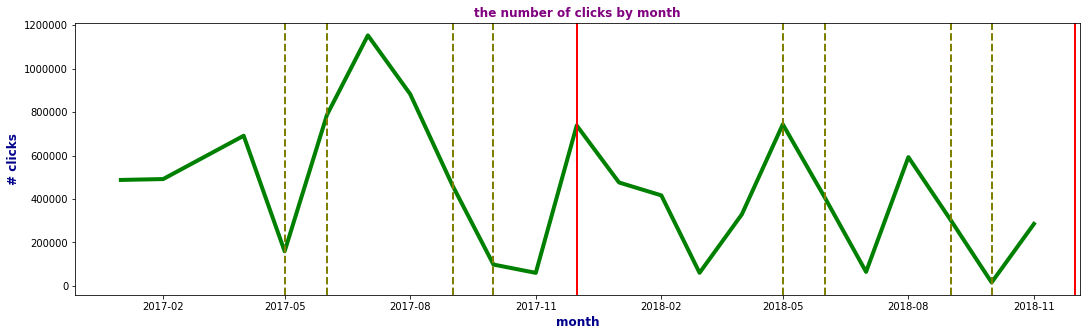

In [31]:
nclicks_by_month = click_data.groupby('file_month').agg({'Url':'count'})
nclicks_by_month = nclicks_by_month.reset_index()

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [18,5]
plt.plot( 'file_month', 'Url', data=nclicks_by_month, marker='', markerfacecolor='green', 
          markersize=12, color='green', linewidth=4)



plt.title("\n".join(wrap("the number of clicks by month",50)),fontweight='bold', color = 'purple', fontsize = 'large')
plt.xlabel("month",fontweight='bold', color = 'darkblue', fontsize = 'large')
plt.ylabel("# clicks",fontweight='bold', color = 'darkblue', fontsize = 'large')
#plt.xticks(counts_by_year_df['year'],fontweight='bold', fontsize = 'large')

for y,m in itertools.product([2017,2018],[5,6,9,10,12]):
    if y != 2019:
        # highlight campaign months
        plt.axvline(x=datetime.datetime(y,m,1), linestyle = '--',color='olive', linewidth=2)


plt.axvline(x=datetime.datetime(2017,12,1), linestyle = '-',color='red', linewidth=2)
plt.axvline(x=datetime.datetime(2018,12,1), linestyle = '-',color='red', linewidth=2)

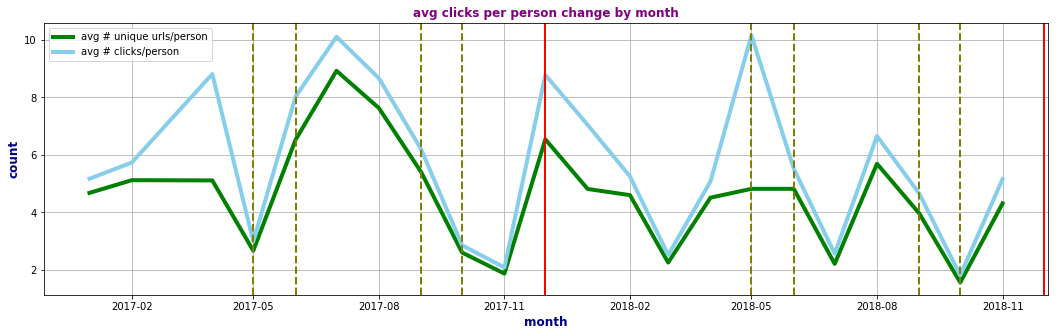

In [33]:
nclicks_by_personh = click_data.groupby(['file_month','Email']).agg({'Url':['count','nunique']})
nclicks_by_personh.columns = ["_".join(x) for x in nclicks_by_personh.columns.ravel()]
nclicks_by_personh = nclicks_by_personh.reset_index()
nclicks_by_person_by_month = nclicks_by_personh.groupby('file_month').agg({'Url_count':'mean','Url_nunique':'mean'})
nclicks_by_person_by_month = nclicks_by_person_by_month.reset_index()

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18,5]
plt.plot( 'file_month', 'Url_nunique', data=nclicks_by_person_by_month, marker='', markerfacecolor='green', 
          markersize=12, color='green', linewidth=4)
plt.plot( 'file_month', 'Url_count',data=nclicks_by_person_by_month, marker='', color='skyblue', linewidth=4)


plt.legend(labels = ['avg # unique urls/person','avg # clicks/person'])
plt.grid(True)
plt.title("\n".join(wrap("avg clicks per person change by month",50)),fontweight='bold', color = 'purple', fontsize = 'large')
plt.xlabel("month",fontweight='bold', color = 'darkblue', fontsize = 'large')
plt.ylabel("count",fontweight='bold', color = 'darkblue', fontsize = 'large')

for y,m in itertools.product([2017,2018],[5,6,9,10,12]):
    if y != 2019:
        # highlight campaign months
        plt.axvline(x=datetime.datetime(y,m,1), linestyle = '--',color='olive', linewidth=2)


plt.axvline(x=datetime.datetime(2017,12,1), linestyle = '-',color='red', linewidth=2)
plt.axvline(x=datetime.datetime(2018,12,1), linestyle = '-',color='red', linewidth=2)

In [34]:
qa = click_data[click_data.file_month.isin(['2017-06-01','2017-07-01','2017-08-01'])].groupby('Url').agg({'Email':'count'})
qa = qa.reset_index()
qa= qa.rename(columns={'Email':'# clicks'})
qa.sort_values(by='# clicks', ascending=False).head(n=10)

,Url,# clicks
1756,http://www.motherjones.com/politics/2017/08/trump-nonstop-lies/,70662
1328,http://www.motherjones.com/media/2017/07/donald-trump-jr-s-email-scandal-lands-cover-of-time/,46504
1743,http://www.motherjones.com/politics/2017/08/teeth-dentists-dental-therapists,45408
1808,http://www.motherjones.com/politics/2017/09/trump-takes-on-stephen-curry-and-colin-kaepernick-in-series-of-rage-tweets/,38972
1682,http://www.motherjones.com/politics/2017/07/holdout-republican-senators-are-being-embraced-by-home-state-crowds-for-opposing-trumpcare/,38566
1088,http://www.motherjones.com/environment/2017/06/trump-pittsburgh-wrong,33427
1254,http://www.motherjones.com/kevin-drum/2017/06/vice-president-pence-lawyers-up/,32038
1104,http://www.motherjones.com/environment/2017/07/timeline-climate-denial-news/,31174
1324,http://www.motherjones.com/media/2017/06/new-yorker-cartoon-hits-at-trumps-fake-time-cover/,30245
1809,http://www.motherjones.com/politics/2017/09/trump-tower-moscow-cnn-document/,29512


In [166]:
click_spring_camp = click_data[click_data['file_month'].dt.month.isin([5,6])].groupby('Email').agg({'Url':'count'})
click_fall_camp = click_data[click_data['file_month'].dt.month.isin([9,10])].groupby('Email').agg({'Url':'count'})
click_dec_camp = click_data[click_data['file_month']==datetime.datetime(2017,12,1)].groupby('Email').agg({'Url':'count'})

click_pre_spring_camp = click_data[click_data['file_month'].dt.month.isin([3,4])].groupby('Email').agg({'Url':'count'})
click_pre_fall_camp = click_data[click_data['file_month'].dt.month.isin([7,8])].groupby('Email').agg({'Url':'count'})
click_pre_dec_camp = click_data[click_data['file_month']==datetime.datetime(2017,11,1)].groupby('Email').agg({'Url':'count'})

click_post_spring_camp = click_data[click_data['file_month'].dt.month.isin([7,8])].groupby('Email').agg({'Url':'count'})
click_post_fall_camp = click_data[click_data['file_month'].dt.month.isin([11])].groupby('Email').agg({'Url':'count'})
click_post_dec_camp = click_data[click_data['file_month']==datetime.datetime(2018,1,1)].groupby('Email').agg({'Url':'count'})



In [171]:
click_spring_camp.head()

,Url
Email,
00005cfbddbc503ae8837036a9b96cec672997922271a736c2253c88108a9c937c65648e3e7232ba8bbc4cab14fef463e94a1acb2287de698d1790af58c4d8d3,21
00011af6cd0911a7cbeb310e069e50c4bf09386813685917b292d4374edf40390928f4107fa551d17611745c6c27a94d3a68401883fcba5531448206975a1988,12
0001340fb0deb54a4ba0fc1f3173986a8cab4d910cc50a84d1a3d2dfb29d626a7b4dc54553c39db0090f3d8d9224bfcdbd1573e27730c11691946f1dc460483f,9
00013854dea798ce10eabfbb2631ac6f67903f4f788d1ee02982e6554b97139ed5a1742559d7730c35af8bfce802ef4fb46f1a16d51d11c909259f86c6ba5e36,11
000200727a4de0dc904374479c764086880a36954e3be960f284f49a2b428d5f68282ceb15e40b1c2bb60ff90ca6a417ce946d7b6b2d0b5c9bac57a0d3906f73,7


In [167]:
click_combo_dic = {'period':['pre-campaign']*(click_pre_spring_camp.shape[0] + click_pre_fall_camp.shape[0] + click_pre_dec_camp.shape[0]) + \
                      ['mid-campaign']*(click_spring_camp.shape[0] + click_fall_camp.shape[0] + click_dec_camp.shape[0]) + \
                      ['post-campaign']*(click_post_spring_camp.shape[0] + click_post_fall_camp.shape[0] + click_post_dec_camp.shape[0]),         
             '# clicks': pd.concat([click_pre_spring_camp,click_pre_fall_camp,click_pre_dec_camp,
                                           click_spring_camp,click_fall_camp,click_dec_camp,
                                           click_post_spring_camp,click_post_fall_camp,click_post_dec_camp])['Url'],
             'campaign':['Spring/Summer']*click_pre_spring_camp.shape[0] + ['Fall']*click_pre_fall_camp.shape[0] + ['Dec']*click_pre_dec_camp.shape[0] + \
                        ['Spring/Summer']*click_spring_camp.shape[0] + ['Fall']*click_fall_camp.shape[0] + ['Dec']*click_dec_camp.shape[0] + \
                        ['Spring/Summer']*click_post_spring_camp.shape[0] + ['Fall']*click_post_fall_camp.shape[0] + ['Dec']*click_post_dec_camp.shape[0]
              
            
            
            
            
            }
click_combo_df = pd.DataFrame.from_dict(click_combo_dic)

In [168]:
m1 = click_combo_df.groupby(['period', 'campaign']).agg({'# clicks':'sum'})
m1 = m1.reset_index()
m1.rename(columns = {'# clicks':'Total Clicks'}, inplace=True)
m1 = pd.concat([m1[m1.period == 'pre-campaign'],m1[m1.period == 'mid-campaign'],m1[m1.period == 'post-campaign']])
m1 = m1.sort_values('campaign', ascending = False)

Text(0.5,1,'Campaign Effectiveness on Total Newsletter Clicks')

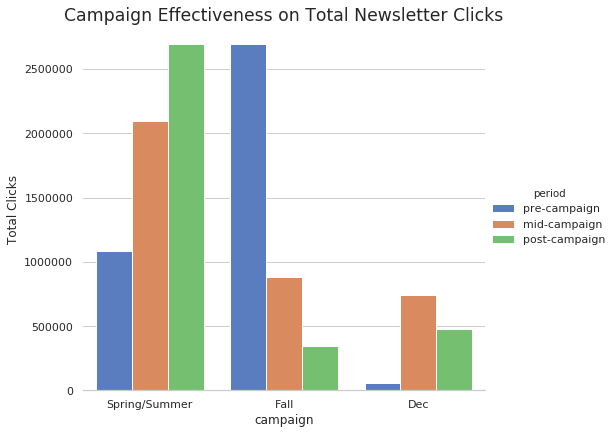

In [169]:
import seaborn as sns
sns.set(style="whitegrid")

# Draw a nested barplot to show survival for class and sex
g = sns.catplot(x="campaign", y="Total Clicks", hue="period", data=m1,
                height=6,aspect=1.2, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Total Clicks")
plt.title('Campaign Effectiveness on Total Newsletter Clicks', fontsize = 'x-large')


Text(0.5,1,'Campaign Effectiveness on Newsletter Clicks per Person')

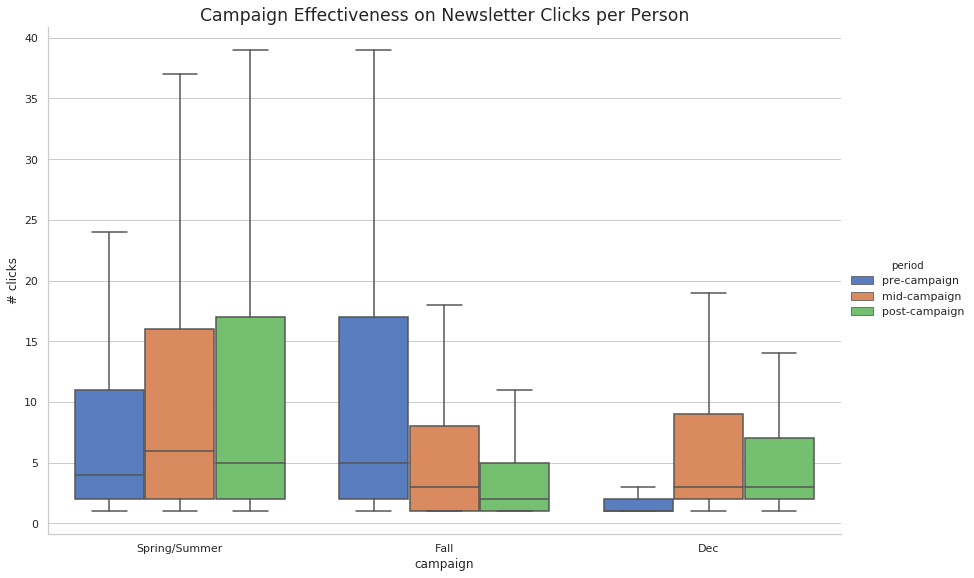

In [170]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
sns.set(style="whitegrid")

testPlot = sns.catplot(x='campaign', y='# clicks',
                       hue='period', data=click_combo_df, palette="muted",
                       showfliers=False,
                       kind='box',height=8, aspect=1.5)

plt.title('Campaign Effectiveness on Newsletter Clicks per Person', fontsize = 'x-large')



Spring Campaign test
8.530750882871038
7.035055457136255
8.09031893875247
Ttest_indResult(statistic=41.9453175684704, pvalue=0.0)
Ks_2sampResult(statistic=0.10234018400335226, pvalue=0.0)
Ttest_indResult(statistic=12.441576928887736, pvalue=1.5922543476534033e-35)
Ks_2sampResult(statistic=0.0804845342035394, pvalue=0.0)

Fall Campaign test
5.996131300138448
8.09031893875247
4.210432291974252
Ttest_indResult(statistic=-61.484124984832924, pvalue=0.0)
Ks_2sampResult(statistic=0.12015524289582658, pvalue=0.0)
Ttest_indResult(statistic=55.3359203029368, pvalue=0.0)
Ks_2sampResult(statistic=0.10927791988363034, pvalue=0.0)

Dec Campaign test
6.222252307692307
2.02093514956154
5.696507372321038
Ttest_indResult(statistic=96.13775409127, pvalue=0.0)
Ks_2sampResult(statistic=0.35322423592836405, pvalue=0.0)
Ttest_indResult(statistic=14.330032484344027, pvalue=1.5266368609746494e-46)
Ks_2sampResult(statistic=0.02699332541669519, pvalue=1.403602467055164e-23)


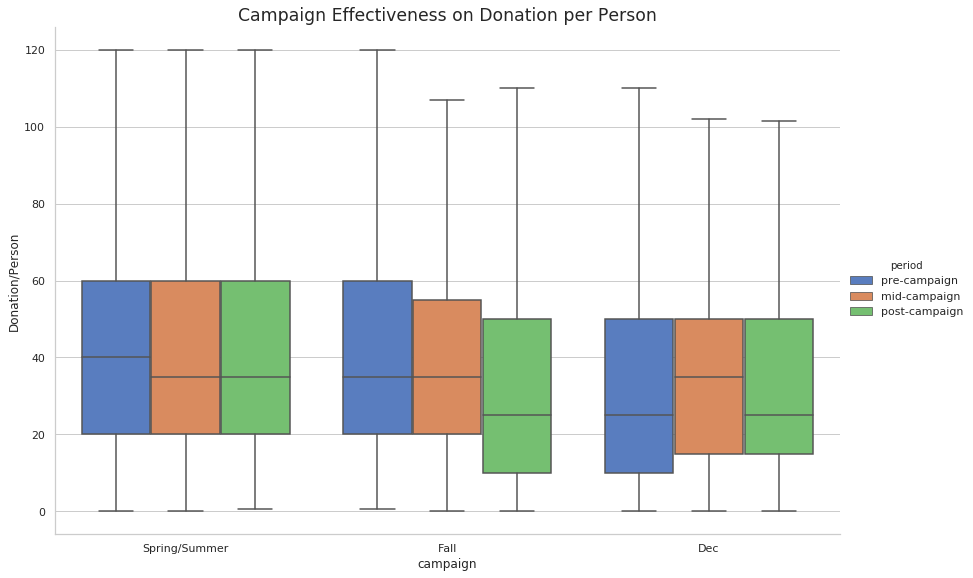

In [176]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
sns.set(style="whitegrid")

testPlot = sns.catplot(x='campaign', y='Donation/Person',
                       hue='period', data=combo_df, palette="muted",
                       showfliers=False,
                       kind='box',height=8, aspect=1.5)

plt.title('Campaign Effectiveness on Donation per Person', fontsize = 'x-large')
m1 = combo_df.groupby(['period', 'campaign'])['Donation/Person'].median().values
mL1 = [str(np.round(s, 2)) for s in m1]


from scipy.stats import ks_2samp
from scipy.stats import ttest_ind
import numpy as np

print("\nSpring Campaign test")
x = click_spring_camp['Url']
y = click_pre_spring_camp['Url']
z = click_post_spring_camp['Url']

x = x[x<40]
y = y[y<40]
z = z[z<40]
print(x.mean())
print(y.mean())
print(z.mean())


print(ttest_ind(x,y))
print(ks_2samp(x,y))
print(ttest_ind(x,z))
print(ks_2samp(x,z))

print("\nFall Campaign test")
x = click_fall_camp['Url']
y = click_pre_fall_camp['Url']
z = click_post_fall_camp['Url']

x = x[x<40]
y = y[y<40]
z = z[z<40]
print(x.mean())
print(y.mean())
print(z.mean())

print(ttest_ind(x,y))
print(ks_2samp(x,y))
print(ttest_ind(x,z))
print(ks_2samp(x,z))

print("\nDec Campaign test")
x = click_dec_camp['Url']
y = click_pre_dec_camp['Url']
z = click_post_dec_camp['Url']

x = x[x<40]
y = y[y<40]
z = z[z<40]
print(x.mean())
print(y.mean())
print(z.mean())


print(ttest_ind(x,y))
print(ks_2samp(x,y))
print(ttest_ind(x,z))
print(ks_2samp(x,z))



## Survival Analysis of how many months people clicked newsletters

In [3]:
import datetime
import calendar

def add_months(sourcedate,months):
    month = sourcedate.month - 1 + months
    year = sourcedate.year + month // 12
    month = month % 12 + 1
    day = min(sourcedate.day,calendar.monthrange(year,month)[1])
    return datetime.date(year,month,day)

def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month

In [4]:
click_data_min = click_data.groupby(['Email']).agg({'file_month':'min'})
click_data_min = click_data_min.reset_index()
clicked_2017 = click_data_min[click_data_min['file_month'] < datetime.datetime(2017,12,1)]['Email']

filtered_click_data = click_data[click_data['Email'].isin(clicked_2017)]


filtered_click_data2 = filtered_click_data.merge(click_data_min, left_on = 'Email', right_on = 'Email')
filtered_click_data2.rename(columns = {'file_month_x':'file_month','file_month_y':'first_month'},inplace=True)

In [5]:
filtered_click_data2['latest_month'] = [ add_months(x,11) for x in filtered_click_data2['first_month']]

filtered_click_data2['latest_month'] = pd.to_datetime(filtered_click_data2['latest_month'])

filtered_click_data2 = filtered_click_data2[filtered_click_data2['file_month'] <= filtered_click_data2['latest_month']]


In [6]:
filtered_click_data2_agg = filtered_click_data2.groupby(['Email']).agg({'file_month':['nunique','max'],
                                                                        'latest_month':'max',
                                                                        'first_month':'max'})
filtered_click_data2_agg.columns = ["_".join(x) for x in filtered_click_data2_agg.columns.ravel()]
filtered_click_data2_agg = filtered_click_data2_agg.reset_index()

filtered_click_data2_agg['month_range'] = [diff_month(x,y)+1 for x, y in zip(filtered_click_data2_agg['file_month_max'],filtered_click_data2_agg['first_month_max'])]
filtered_click_data2_agg['is_censored'] = [int(x) for x in (filtered_click_data2_agg['file_month_max'] == filtered_click_data2_agg['latest_month_max'])]

In [7]:
#print(click_data_agg['file_month'].describe())
#print(click_data_agg[click_data_agg['Email'].isin(donors)]['file_month'].describe())
#print(click_data_agg[~click_data_agg['Email'].isin(donors)]['file_month'].describe())
print('{}% emails were censored cuz they are active users'.format(round(100*filtered_click_data2_agg.is_censored.mean(),2)))
#print(filtered_click_data2_agg['month_range'][filtered_click_data2_agg['is_censored'] != 1].describe())
print(filtered_click_data2_agg['month_range'].describe())

35.96% emails were censored cuz they are active users
count    179064.000000
mean     7.351595     
std      4.505971     
min      1.000000     
25%      2.000000     
50%      8.000000     
75%      12.000000    
max      12.000000    
Name: month_range, dtype: float64


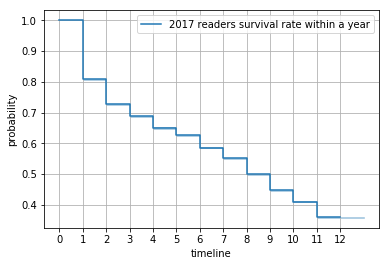

In [8]:
from lifelines import KaplanMeierFitter

## Example Data 
#durations = click_data_agg['file_month']
#event_observed = [1]*click_data_agg.shape[0]
durations = filtered_click_data2_agg['month_range']
event_observed = 1-filtered_click_data2_agg['is_censored']

## create a kmf object
kmf = KaplanMeierFitter() 

## Fit the data into the model
kmf.fit(durations, event_observed,label='2017 readers survival rate within a year')

a1 = kmf.plot(ci_show=True)
a1.set_xticks(range(0,max(filtered_click_data2_agg['month_range'])+1))
a1.set_ylabel("probability")
#a1.axhline(y=0.8, linestyle = '--',color='olive', linewidth=2)
a1.grid()

49.88% emails were censored cuz they are active users
count    16203.000000
mean     8.280689    
std      4.481273    
min      1.000000    
25%      3.000000    
50%      11.000000   
75%      12.000000   
max      12.000000   
Name: month_range, dtype: float64
34.58% emails were censored cuz they are active users
count    162861.00000
mean     7.25916     
std      4.49795     
min      1.00000     
25%      2.00000     
50%      8.00000     
75%      12.00000    
max      12.00000    
Name: month_range, dtype: float64


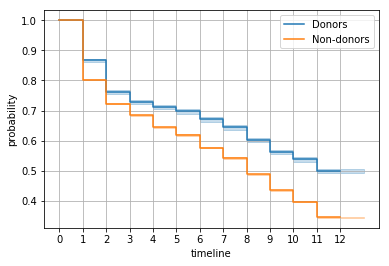

In [12]:
from lifelines import KaplanMeierFitter

## Example Data 
donors = donation[(donation['ORD ENTR DT'] > datetime.datetime(2017,1,1)) & (donation['ORD ENTR DT'] < datetime.datetime(2018,12,31))]['EMAIL'].unique()
durations_donors = filtered_click_data2_agg[filtered_click_data2_agg['Email'].isin(donors)]['month_range']
event_observed_donors = 1-filtered_click_data2_agg[filtered_click_data2_agg['Email'].isin(donors)]['is_censored']

print('{}% emails were censored cuz they are active users'.format(round(100*filtered_click_data2_agg[filtered_click_data2_agg['Email'].isin(donors)]['is_censored'].mean(),2)))
#print(filtered_click_data2_agg['month_range'][filtered_click_data2_agg['is_censored'] != 1].describe())
print(filtered_click_data2_agg[filtered_click_data2_agg['Email'].isin(donors)]['month_range'].describe())

durations_nondonors = filtered_click_data2_agg[~filtered_click_data2_agg['Email'].isin(donors)]['month_range']
event_observed_nondonors = 1-filtered_click_data2_agg[~filtered_click_data2_agg['Email'].isin(donors)]['is_censored']
print('{}% emails were censored cuz they are active users'.format(round(100*filtered_click_data2_agg[~filtered_click_data2_agg['Email'].isin(donors)]['is_censored'].mean(),2)))
#print(filtered_click_data2_agg['month_range'][filtered_click_data2_agg['is_censored'] != 1].describe())
print(filtered_click_data2_agg[~filtered_click_data2_agg['Email'].isin(donors)]['month_range'].describe())


## create a kmf object
kmf1 = KaplanMeierFitter() 

kmf1.fit(durations_donors, event_observed_donors, label='Donors')
a1 = kmf1.plot()
a1.set_xticks(range(0,max(filtered_click_data2_agg['month_range'])+1))
a1.set_ylabel("probability")

## fit the model for 2nd cohort
kmf1.fit(durations_nondonors, event_observed_nondonors, label='Non-donors')
kmf1.plot(ax=a1)
a1.grid()

### subscription data basic counts summary

In [41]:
print('### SUBSCRIPTION ###')
print("Data date ranges from {} to {}".format(subscription_counts['min_date'].date(),subscription_counts['max_date'].date()))
print("count of unique emails: {}".format(str(subscription_counts['nemails'])))
print("count of unique emails by pub code:") 
display(subscription_counts['nemails_by_pub'])

print('count of overlap between pub codes: {}'.format(subscription_counts['noverlap']))



### SUBSCRIPTION ###
Data date ranges from 2016-01-04 to 2018-12-31
count of unique emails: 80660
count of unique emails by pub code:


,EMAIL
ORD-PUB-CODE,
MJM,80660


count of overlap between pub codes: 0


### donation data basic counts summary

In [42]:
print('### DONATION ###')
print("Data date ranges from {} to {}".format(donation_counts['min_date'].date(),donation_counts['max_date'].date()))
print("count of unique emails: {}".format(str(donation_counts['nemails'])))
print("count of unique emails by pub code:") 
display(donation_counts['nemails_by_pub'])
print(donation_counts['nemails_by_pub']/donation_counts['nemails'])
print('\n')
print('count of emails having both DON and SDN: {}'.format(donation_counts['noverlap']))
print('%{} donoars have both DON and SDN'. format(round(donation_counts['noverlap']/donation_counts['nemails']*100,2)))

### DONATION ###
Data date ranges from 2016-01-01 to 2018-12-31
count of unique emails: 69424
count of unique emails by pub code:


,EMAIL
ORD-PUB-CODE,
DON,62133
SDN,10510


                 EMAIL
ORD-PUB-CODE          
DON           0.894979
SDN           0.151389


count of emails having both DON and SDN: 3219
%4.64 donoars have both DON and SDN


### aggregates email counts by donation amount per person

#### note: 1066 donation records have amount = 0 (donation[donation['AMT PAID']==0].shape)


In [7]:
cnts = combined[(combined['don_freq'] > 0)].groupby('don_total').agg({'Email': 'count'})
cnts = cnts.reset_index()
cnts['Email_cumpct'] = 100*(cnts['Email']/cnts['Email'].sum()).cumsum()
cnts['don_total_cum'] = cnts['don_total']*cnts['Email']
cnts['don_total_cumpct'] = 100*(cnts['don_total_cum'].cumsum())/(cnts['don_total_cum'].sum())
cnts.head()

,don_total,Email,Email_cumpct,don_total_cum,don_total_cumpct
0,0.01,6,0.008643,0.06,7.660088e-07
1,0.03,1,0.010083,0.03,1.149013e-06
2,0.05,2,0.012964,0.10,2.425695e-06
3,0.09,1,0.014404,0.09,3.574708e-06
4,0.10,1,0.015845,0.10,4.851389e-06


In [6]:
(cnts['don_total_cum'].sum())

7832808.049999999

### histogram of all the donations

Text(0,0.5,'counts')

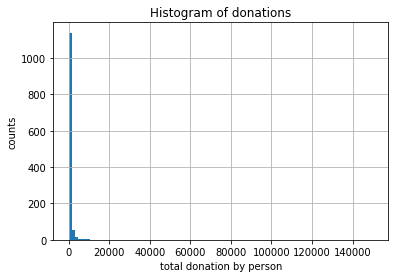

In [9]:
import pylab as pl
cnts_hist = cnts.hist(column = 'don_total', bins = 100)
pl.title("Histogram of donations")
pl.xlabel("total donation by person")
pl.ylabel("counts")

### histogram of donations below $1000

Text(0,0.5,'counts')

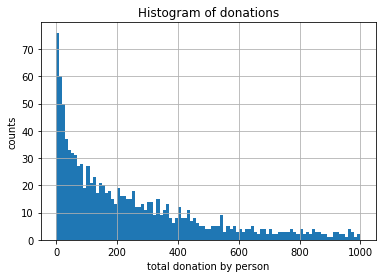

In [10]:
import pylab as pl
cnts_hist = cnts.hist(column = 'don_total', bins = 100, range = [0,1000])
pl.title("Histogram of donations")
pl.xlabel("total donation by person")
pl.ylabel("counts")

### analyze the relationship between cumulative donation and cumulative email freq

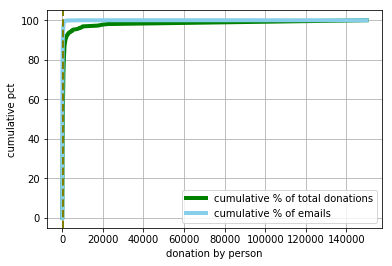

In [11]:
import matplotlib.pyplot as plt
plt.plot( 'don_total', 'don_total_cumpct', data=cnts, marker='', markerfacecolor='green', markersize=12, color='green', linewidth=4)
plt.plot( 'don_total', 'Email_cumpct',data=cnts, marker='', color='skyblue', linewidth=4)
plt.legend(labels = ['cumulative % of total donations','cumulative % of emails'])
plt.grid(True)
pl.title("")
pl.xlabel("donation by person")
pl.ylabel("cumulative pct")

plt.axvline(x=500, linestyle = '--',color='olive', linewidth=2)
#plt.axhline(y=cnts['Email_cumpct'][cnts['don_total']==300].unique(), linestyle = '-')

### analyze the relationship between cumulative donation and cumulative email freq for donation below $1000

913    96.881482
Name: Email_cumpct, dtype: float64
913    70.61925
Name: don_total_cumpct, dtype: float64


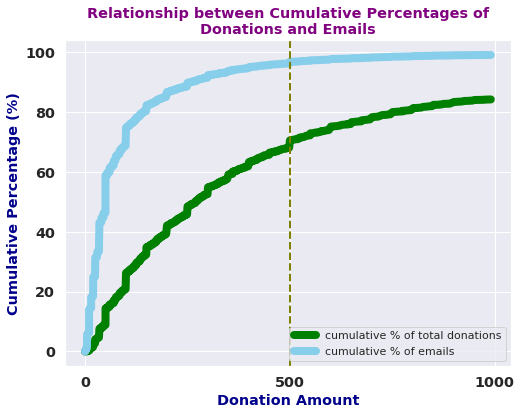

In [12]:
import seaborn as sns; 
sns.set()
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 6]
plt.plot( 'don_total', 'don_total_cumpct', data=cnts[cnts['don_total'] < 1000], marker='', markerfacecolor='green', markersize=12, color='green', linewidth=8)
plt.plot( 'don_total', 'Email_cumpct',data=cnts[cnts['don_total'] < 1000], marker='', color='skyblue', linewidth=8)
plt.legend(labels = ['cumulative % of total donations','cumulative % of emails'])
plt.grid(True)
plt.title("\n".join(wrap("Relationship between Cumulative Percentages of Donations and Emails",50)),fontweight='bold', color = 'purple', fontsize = 'large')
plt.xlabel("Donation Amount",fontweight='bold', color = 'darkblue', fontsize = 'large')
plt.ylabel("Cumulative Percentage (%)",fontweight='bold', color = 'darkblue', fontsize = 'large')
plt.xticks([0,500,1000],fontweight='bold', fontsize = 'large')
plt.yticks(np.arange(0, 101, step=20),fontweight='bold', fontsize = 'large')
plt.axvline(x=500, linestyle = '--',color='olive', linewidth=2)
print(cnts['Email_cumpct'][cnts['don_total']==500])
print(cnts['don_total_cumpct'][cnts['don_total']==500])

In [13]:
print(cnts['Email_cumpct'][cnts['don_total']  > 1000].head())
print(cnts['don_total_cumpct'][cnts['don_total'] > 1000].head())

1073    99.359011
1074    99.360452
1075    99.366213
1076    99.367654
1077    99.369094
Name: Email_cumpct, dtype: float64
1073    85.968335
1074    85.981230
1075    86.033318
1076    86.046355
1077    86.059415
Name: don_total_cumpct, dtype: float64


In [14]:
unique_years = donation['ORD ENTR DT'].dt.year.unique()

high_value_donor_by_year = {'year':[],
                            '% high-value donors':[],
                            '% high-value donation':[],
                            'total donation':[],
                            'total donors':[]}
for single_year in unique_years:

    single_don = donation[donation['ORD ENTR DT'].dt.year == single_year]
    single_don_total = single_don.groupby('EMAIL').agg({'AMT PAID':'sum'})
    
    
    pct_hv_donors = (single_don_total['AMT PAID'] > 500).mean()
    total_donors = single_don_total.shape[0]
    total_donation = round(sum(single_don_total['AMT PAID']))
    total_hv_donotion = sum(single_don_total['AMT PAID'][single_don_total['AMT PAID'] > 500])
    
    high_value_donor_by_year['year'].append(single_year)
    high_value_donor_by_year['% high-value donors'].append("{:}%".format(round(pct_hv_donors*100,2)))
    high_value_donor_by_year['% high-value donation'].append("{:}%".format(round(total_hv_donotion/total_donation*100,2)))
    high_value_donor_by_year['total donation'].append("${:,}".format(total_donation))
    high_value_donor_by_year['total donors'].append(total_donors)
    
    
df = pd.DataFrame.from_dict(high_value_donor_by_year)
df = df[['year','total donation','total donors','% high-value donation','% high-value donors']]
df.sort_values(by = 'year')

,year,total donation,total donors,% high-value donation,% high-value donors
2,2016,"$2,167,072",30897,16.74%,0.62%
0,2017,"$2,901,778",35715,13.37%,0.91%
1,2018,"$2,763,958",36321,12.75%,0.83%


## Q1. Which donors are also subscribers and vice versa?

### create confusion matrix between donors and subscribers and find overlap

In [55]:
combined_cf = pd.crosstab(combined['subs_freq'].astype('bool'), 
                          combined['don_freq'].astype('bool'), 
                          rownames=['subscription'], 
                          colnames=['donation'], margins=True)
print('confusion matrix of magazine subscription and donation')
print('\n')
print(combined_cf)
print('\n')
print('{}% of magazine subscribers also donated'.format(round(100*combined_cf.iloc[1,1]/combined_cf.iloc[1,2])))
print('{}% of magazine subscribers also are recurring donors'.format(round(100*sum(combined[(combined['subs_freq'] > 0) & (combined['don_freq'] > 0)]['SDN'])/combined_cf.iloc[1,2])))

print('{}% of donors are magazine subscribers'.format(round(100*combined_cf.iloc[1,1]/combined_cf.iloc[2,1])))

don_clicked_url = sum((sub_don_click_combined['don_freq'] > 0) & (sub_don_click_combined['Url']>0))
total_donor = sum(sub_don_click_combined['don_freq'] > 0)

print('Also, {} donors clicked Oct newsletter ({}%)'.format(don_clicked_url,round(don_clicked_url/total_donor*100,2)))
    

confusion matrix of magazine subscription and donation


donation      False   True     All
subscription                      
False         0      47146  47146 
True          58382  22278  80660 
All           58382  69424  127806


28.0% of magazine subscribers also donated
8.0% of magazine subscribers also are recurring donors
32.0% of donors are magazine subscribers
Also, 23535 donors clicked Oct newsletter (33.9%)


### analyze the overlap change by year

In [13]:
import numpy
unique_years = subscription['ORD ENTR DT'].dt.year.unique()

overlap_by_year = {'year':[],'overlap':[],'nsub':[],'ndon':[]}

for single_year in unique_years:
    single_sub = subscription[subscription['ORD ENTR DT'].dt.year == single_year].EMAIL.unique()
    single_don = donation[donation['ORD ENTR DT'].dt.year == single_year].EMAIL.unique()
    overlap_by_year['year'].append(single_year)
    
    noverlap = len(numpy.intersect1d(single_sub,single_don))
    nsub = len(single_sub)
    ndon = len(single_don)

    overlap_by_year['overlap'].append(noverlap)
    overlap_by_year['nsub'].append(nsub)
    overlap_by_year['ndon'].append(ndon)
    
df = pd.DataFrame.from_dict(overlap_by_year)
df['sub_pct'] = ['{:.1%}'.format(x) for x in df['overlap']/df['nsub']]
df['don_pct'] = ['{:.1%}'.format(x) for x in df['overlap']/df['ndon']]

df = df[['year','ndon','nsub','overlap','sub_pct','don_pct']]

df = df.rename(columns={'ndon':'# donors','nsub':'# subscribers',
                  'overlap':'# overlap','sub_pct':'% subscribers who donated','don_pct':'% donors who subscribed'})

df.style.set_table_styles([dict(selector="th",props=[('max-width', '100px')])])

,year,# donors,# subscribers,# overlap,% subscribers who donated,% donors who subscribed
0,2016,30897,30765,5165,16.8%,16.7%
1,2017,35715,39646,6603,16.7%,18.5%
2,2018,36321,29542,5132,17.4%,14.1%


### check how many magazine subscribers renewed

In [56]:
# exclude users who subscribed the first time within a year
blacklist_emails = combined[(combined['subs_freq'] ==1) & (combined['subs_recency']<360)]
potential_renew_subscribers = combined[(combined['subs_freq'] >0 ) & (~combined['Email'].isin(blacklist_emails['Email']))]

renew_rate = ((potential_renew_subscribers['subs_freq']> 1) & (potential_renew_subscribers['subs_range']> 300)).mean()
# assume people only renew within 60 days of expiration
print("magazine renew rate is " + str(round(renew_rate*100,2)) + '%')

magazine renew rate is 42.38%


### If people both donated and subcribed, did they donate first or subscribe first? How many days between the two actions?

In [87]:
both_donor_sub = sub_don_click_combined[(sub_don_click_combined['subs_freq'] > 0) & (sub_don_click_combined['don_freq'] > 0)]
both_donor_sub['earliest_don'] = both_donor_sub['don_range'] +  both_donor_sub['don_recency']
both_donor_sub['earliest_sub'] = both_donor_sub['subs_range'] +  both_donor_sub['subs_recency']

both_donor_sub['earliest_don_date'] = both_donor_sub['process_date'] + [datetime.timedelta(days = -x) for x in both_donor_sub['earliest_don']]
both_donor_sub['earliest_sub_date'] = both_donor_sub['process_date'] + [datetime.timedelta(days = -x) for x in both_donor_sub['earliest_sub']]


both_donor_sub = both_donor_sub[['earliest_don','earliest_sub','earliest_don_date','earliest_sub_date']]
both_donor_sub = both_donor_sub.reset_index()

/home/centos/mojo/mojoenv/lib/python3.4/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/centos/mojo/mojoenv/lib/python3.4/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/centos/mojo/mojoenv/lib/python3.4/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pand

In [88]:
def transition_type(earliest_don, earliest_sub):
    if earliest_don > earliest_sub:
        return 'Donate first'
    if earliest_don < earliest_sub:
        return 'Subscribe first'
    if earliest_don == earliest_sub:
        return 'Donate and subscribe on the same day'
  

    

both_donor_sub['transition_type'] = both_donor_sub.apply(lambda x: transition_type(x[1],x[2]), axis=1)
both_donor_sub['transition_period'] = abs(both_donor_sub['earliest_don'] - both_donor_sub['earliest_sub'])
both_donor_sub_transition = both_donor_sub.groupby('transition_type').agg({'Email':'count','transition_period':'median'})
both_donor_sub_transition = both_donor_sub_transition.rename(columns = {'Email': 'email count',
                                             'transition_period': 'average days between transition'})
both_donor_sub_transition['email pct (%)'] = round(both_donor_sub_transition['email count']/both_donor_sub_transition['email count'].sum()*100,2)
both_donor_sub_transition[['email pct (%)','average days between transition']]

,email pct (%),average days between transition
transition_type,,
Donate and subscribe on the same day,29.90,0.0
Donate first,43.20,38.0
Subscribe first,26.89,196.0


### aggregate by month to see how many transitions happened each month

In [103]:
either_donor_sub = sub_don_click_combined[(sub_don_click_combined['subs_freq'] > 0) |  (sub_don_click_combined['don_freq'] > 0)]
either_donor_sub['earliest_don'] = either_donor_sub['don_range'] +  either_donor_sub['don_recency']
either_donor_sub['earliest_sub'] = either_donor_sub['subs_range'] +  either_donor_sub['subs_recency']

either_donor_sub['earliest_don_date'] = either_donor_sub['process_date'] + [datetime.timedelta(days = -x) for x in either_donor_sub['earliest_don']]
either_donor_sub['earliest_sub_date'] = either_donor_sub['process_date'] + [datetime.timedelta(days = -x) for x in either_donor_sub['earliest_sub']]
either_donor_sub['earliest_don_date'] = pd.to_datetime(either_donor_sub['earliest_don_date'])
either_donor_sub['earliest_sub_date'] = pd.to_datetime(either_donor_sub['earliest_sub_date'])
either_donor_sub=either_donor_sub.reset_index()

In [104]:
sub_first = both_donor_sub[both_donor_sub.transition_type == 'Subscribe first']

sub2don_track = {'n_potential_sub_donors':[],'n_sub2don':[],'year_month':[]}
for single_year, single_month in itertools.product([2017,2018],range(1,13)):
    
    m = datetime.datetime(single_year, single_month,1)
    
    n_potential_sub_donors = len(either_donor_sub[(either_donor_sub['earliest_sub_date'] < m) & \
                                                  (either_donor_sub['earliest_don_date'] > m)]['Email'].unique())
    sub2don_track['n_potential_sub_donors'].append(n_potential_sub_donors)
    
    n_sub2don = len(sub_first[(pd.to_datetime(sub_first.earliest_don_date).dt.year == single_year) & (pd.to_datetime(sub_first.earliest_don_date).dt.month == single_month)]['Email'].unique())
    sub2don_track['n_sub2don'].append(n_sub2don)
    
    sub2don_track['year_month'].append(datetime.datetime(single_year,single_month,1))

sub2don_track_df = pd.DataFrame(sub2don_track)
sub2don_track_df['transit_rate'] = sub2don_track_df['n_sub2don']/sub2don_track_df['n_potential_sub_donors']

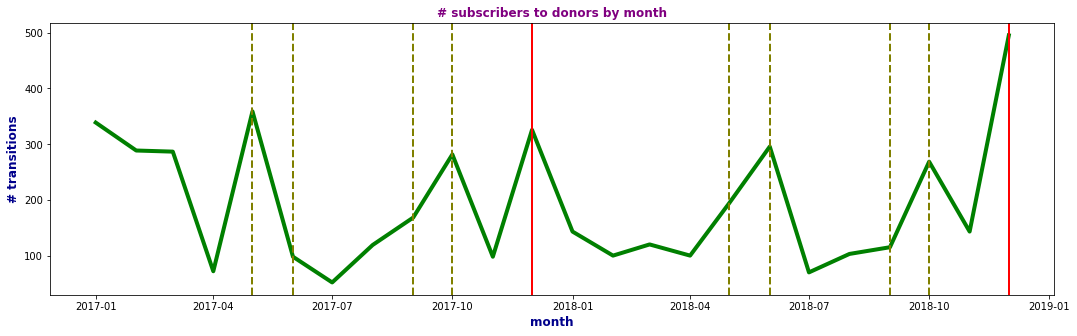

In [108]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18,5]
plt.plot( 'year_month', 'n_sub2don', data=sub2don_track_df, marker='', markerfacecolor='green', 
          markersize=12, color='green', linewidth=4)



plt.title("\n".join(wrap("# subscribers to donors by month",50)),fontweight='bold', color = 'purple', fontsize = 'large')
plt.xlabel("month",fontweight='bold', color = 'darkblue', fontsize = 'large')
plt.ylabel("# transitions",fontweight='bold', color = 'darkblue', fontsize = 'large')
#plt.xticks(counts_by_year_df['year'],fontweight='bold', fontsize = 'large')

for y,m in itertools.product([2017,2018],[5,6,9,10,12]):
    if y != 2019:
        # highlight campaign months
        plt.axvline(x=datetime.datetime(y,m,1), linestyle = '--',color='olive', linewidth=2)


plt.axvline(x=datetime.datetime(2017,12,1), linestyle = '-',color='red', linewidth=2)
plt.axvline(x=datetime.datetime(2018,12,1), linestyle = '-',color='red', linewidth=2)

In [113]:
don_first = both_donor_sub[both_donor_sub.transition_type == 'Donate first']

don2sub_track = {'n_potential_don_sub':[],'n_don2sub':[],'year_month':[]}
for single_year, single_month in itertools.product([2017,2018],range(1,13)):
    
    m = datetime.datetime(single_year, single_month,1)
    
    n_potential_don_sub = len(either_donor_sub[(either_donor_sub['earliest_don_date'] < m) & \
                                               (either_donor_sub['earliest_sub_date'] > m)]['Email'].unique())
    don2sub_track['n_potential_don_sub'].append(n_potential_don_sub)
    
    
    
    n_don2sub = len(don_first[(pd.to_datetime(don_first.earliest_sub_date).dt.year == single_year) \
                              & (pd.to_datetime(don_first.earliest_sub_date).dt.month == single_month)]['Email'].unique())
    don2sub_track['n_don2sub'].append(n_don2sub)
    
    don2sub_track['year_month'].append(datetime.datetime(single_year,single_month,1))

don2sub_track_df = pd.DataFrame(don2sub_track)
don2sub_track_df['transit_rate'] = don2sub_track_df['n_don2sub']/don2sub_track_df['n_potential_don_sub']

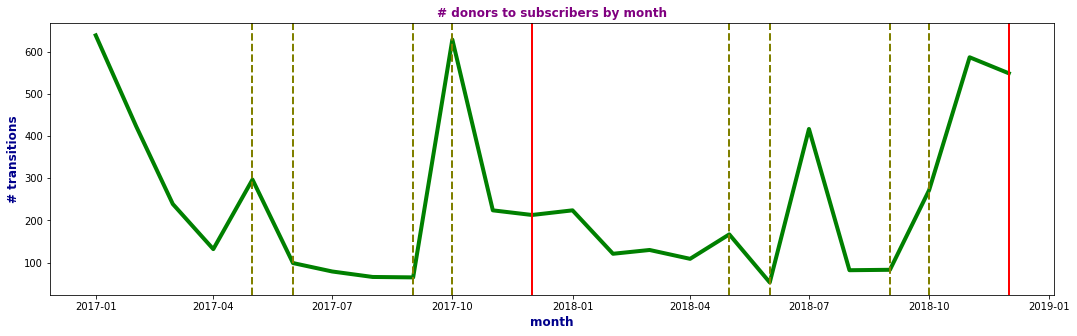

In [115]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18,5]
plt.plot( 'year_month', 'n_don2sub', data=don2sub_track_df, marker='', markerfacecolor='green', 
          markersize=12, color='green', linewidth=4)



plt.title("\n".join(wrap("# donors to subscribers by month",50)),fontweight='bold', color = 'purple', fontsize = 'large')
plt.xlabel("month",fontweight='bold', color = 'darkblue', fontsize = 'large')
plt.ylabel("# transitions",fontweight='bold', color = 'darkblue', fontsize = 'large')
#plt.xticks(counts_by_year_df['year'],fontweight='bold', fontsize = 'large')

for y,m in itertools.product([2017,2018],[5,6,9,10,12]):
    if y != 2019:
        # highlight campaign months
        plt.axvline(x=datetime.datetime(y,m,1), linestyle = '--',color='olive', linewidth=2)


plt.axvline(x=datetime.datetime(2017,12,1), linestyle = '-',color='red', linewidth=2)
plt.axvline(x=datetime.datetime(2018,12,1), linestyle = '-',color='red', linewidth=2)

### average donation from subscriber donors vs non-subscriber donors 

In [54]:
sub_don_avg = combined[(combined['don_freq'] > 0) & (combined['subs_freq'] > 0)]['don_total'].median()
nonsub_don_avg = combined[(combined['don_freq'] > 0) & (combined['subs_freq'] == 0)]['don_total'].median()
pct_high_sub_don = round(100*(combined[(combined['don_freq'] > 0) & (combined['subs_freq'] > 0)]['don_total'] > 300).mean(),2)
pct_high_nonsub_don = round(100*(combined[(combined['don_freq'] > 0) & (combined['subs_freq'] == 0)]['don_total'] > 300).mean(),2)

print('subscriber donors donated ${} on average'.format(sub_don_avg))
print('{}% subscriber donors donated over $300'.format(pct_high_sub_don))
print('non-subscriber donors donated ${} on average'.format(nonsub_don_avg))
print('{}% non-subscriber donors donated over $300'.format(pct_high_nonsub_don))

subscriber donors donated $60.0 on average
11.23% subscriber donors donated over $300
non-subscriber donors donated $35.0 on average
3.99% non-subscriber donors donated over $300


## Q2. What kinds of leads generate the most high-value donors?

Not answerable 

Henry's Note:
Ask MJ what they mean by the "kinds" of leads.

Adam will provide fundraising emails that may be a way for us to tackle this.  They may have some data about the leads, the types of fundraising email, and what in the email the lead engaged with.

Adam will also follow up internally to better define what features they would be interested in exploring when they say "kind of leads", and see if there are data sources to get a handle on that.

### some insights into high-value donors

### data prep: dive donors into multiple groups
- regular donors (< 500 dollars)
- highvalue donors (>= 500 dollars)
- SDN donors
- one-time big time donor
- multi-time non SDN donors
- non donors
- all donors

In [7]:
# create a dictionary with different donor groups
donor_groups = define_donor_groups(df = sub_don_click_combined)

for i in donor_groups.keys():
    print(i)

regular donors (< $500)
highvalue donors (>= $500)
SDN donors
one-time big time donor
multi-time non SDN donors
non donors
all donors


### a. How many are high-value donors? How much are their donations? Are they one-time big check donor or frequent small amount donors

In [18]:
n_high_value_donors = donor_groups['highvalue donors (>= $500)'].shape[0]
n_total_donors = combined.loc[combined['don_total'] > 0].shape[0]
total_donation = round(sum(donor_groups['all donors']['don_total']))
total_highvalue_donation = round(sum(donor_groups['highvalue donors (>= $500)']['don_total']))

print('number of high-value donors:{}'.format(n_high_value_donors))
print('{}% of donnars are high-value donors'.format(round(100*n_high_value_donors/n_total_donors,2)))
print('total donation:${}'.format(total_donation))
print('total donation from high-value donors: ${} ({}%)'.
     format(total_highvalue_donation,
            round(total_highvalue_donation/total_donation*100, 2)))


number of high-value donors:526
1.44% of donnars are high-value donors
total donation:$2949751
total donation from high-value donors: $453636 (15.38%)


In [19]:
n_SDN_highdonors = donor_groups['SDN donors'].shape[0]
total_SDN_donation = round(sum(donor_groups['SDN donors']['don_total']))

n_onetime_DON_highdonors = donor_groups['one-time big time donor'].shape[0]
total_onetime_DON_donation = round(sum(donor_groups['one-time big time donor']['don_total']))

n_multitime_DON_highdonors = donor_groups['multi-time non SDN donors'].shape[0]
total_multitime_DON_donation = round(sum(donor_groups['multi-time non SDN donors']['don_total']))


print('number of SDN: {}; donated ${}'.format(n_SDN_highdonors,total_SDN_donation))


print('number of one time donors: {}; donated ${}'.format(n_onetime_DON_highdonors,total_onetime_DON_donation))


print('number of multi-time non SDN donors: {}; donated ${}'.format(n_multitime_DON_highdonors,total_multitime_DON_donation))


number of SDN: 156; donated $134091
number of one time donors: 226; donated $207046
number of multi-time non SDN donors: 144; donated $112498


### b. are high-value donors also magazine subscribers or newsletter subuscribers? what are their interested topics?

In [20]:
# use OrderedDict to keep results in certain order
donor_groups_summary = []

for grpname, dat in donor_groups.items():
    
    donor_groups_summary.append(check_subscription_rate(df =dat, groupname =grpname))
    

donor_groups_summary_df = pd.DataFrame.from_records(donor_groups_summary)
donor_groups_summary_df = donor_groups_summary_df.rename(columns = {0:'donor groupname',
                                                                    1: 'magazine subscription rate',
                                                                    2: 'newsletter click rate'})

print("compare magazine subscription rate and newsletter click rate by each donor group ")   
donor_groups_summary_df

compare magazine subscription rate and newsletter click rate by each donor group 


,donor groupname,magazine subscription rate,newsletter click rate
0,regular donors (< $500),25.12,14.78
1,highvalue donors (>= $500),22.24,18.44
2,SDN donors,15.38,26.28
3,one-time big time donor,22.57,10.62
4,multi-time non SDN donors,29.17,22.22
5,non donors,100.00,6.40
6,all donors,25.08,14.83


In [21]:
donor_groups_click_summary = []

for grpname, dat in donor_groups.items():
    
    donor_groups_click_summary.append(check_click_distribution(df =dat, groupname =grpname))
    
print("compare # urls clicked by each donor group ")    
pd.concat(donor_groups_click_summary, axis=1)


compare # urls clicked by each donor group 


,regular donors (< $500),highvalue donors (>= $500),SDN donors,one-time big time donor,multi-time non SDN donors,non donors,all donors
count,5313.00,97.00,41.00,24.00,32.00,2692.00,5410.00
mean,6.45,7.02,7.17,4.04,9.06,4.66,6.46
std,10.00,8.70,8.45,3.93,10.92,8.52,9.97
min,1.00,1.00,1.00,1.00,1.00,1.00,1.00
25%,2.00,2.00,2.00,1.00,2.00,1.00,2.00
50%,3.00,4.00,4.00,3.50,4.50,2.00,3.00
75%,8.00,8.00,9.00,5.00,9.00,5.00,8.00
max,238.00,42.00,42.00,18.00,41.00,242.00,238.00


In [30]:
topics = ['about','crime-justice','environment','food','media','politics','topics']
comparison_groups = ['highvalue donors (>= $500)','regular donors (< $500)','non donors']
combo = pd.concat([sub_df_colsum(df = donor_groups[k],cols = topics, name = k) for k in comparison_groups],axis=1)

# convert to click percentage
for g in comparison_groups:
      combo[g] = round(combo[g]/sum(donor_groups[g]['All'])*100,2) 
     
        

print('compare none donors (people never donated), regular donors and high-value donors of the topics they clicked')
print('all the numbers are the percentage of urls containing the certain topics')

combo

compare none donors (people never donated), regular donors and high-value donors of the topics they clicked
all the numbers are the percentage of urls containing the certain topics


,highvalue donors (>= $500),regular donors (< $500),non donors
about,0.00,0.01,0.02
crime-justice,0.44,0.30,0.31
environment,21.00,19.05,18.63
food,6.75,6.11,6.56
media,3.52,2.89,2.32
politics,56.39,59.50,58.98
topics,0.00,0.08,0.10


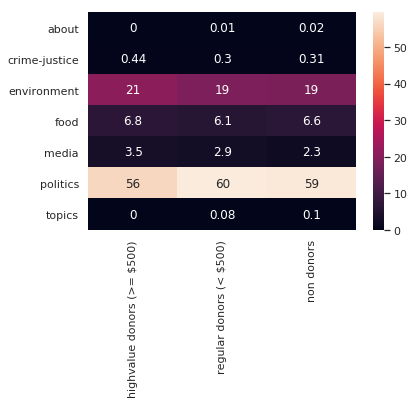

In [32]:
# heat of the table above
import seaborn as sns; sns.set()
sns.heatmap(combo, annot=True)

In [33]:
# donors from the month
min_date = datetime.date(2018, 9, 19)
max_date = datetime.date(2018, 10, 30)
oct_donors = donation[(donation['ORD ENTR DT'] > min_date) & (donation['ORD ENTR DT'] < max_date)]['EMAIL'].unique().tolist()


donor_groups['campaign_highvalue_donors'] = sub_don_click_combined.loc[(sub_don_click_combined['don_total'] >= 500) & sub_don_click_combined.index.isin(oct_donors) ]
donor_groups['campaign_regular_donors'] = sub_don_click_combined.loc[(sub_don_click_combined['don_total'] > 0) & (sub_don_click_combined['don_total'] < 500)& sub_don_click_combined.index.isin(oct_donors) ]


In [35]:
topics = ['about','crime-justice','environment','food','media','politics','topics']
comparison_groups = ['non donors',
                     'regular donors (< $500)',
                     'highvalue donors (>= $500)',
                     'campaign_regular_donors',
                     'campaign_highvalue_donors'
                    ]
combo = pd.concat([sub_df_colsum(df = donor_groups[k],cols = topics, name = k) for k in comparison_groups],axis=1)

# convert to click percentage
for g in comparison_groups:
      combo[g] = round(combo[g]/sum(donor_groups[g]['All'])*100,2) 
     

print('compare none donors (people never donated), regular donors and high-value donors of the topics they clicked')
print('all the numbers are the percentage of urls containing the certain topics')

combo

compare none donors (people never donated), regular donors and high-value donors of the topics they clicked
all the numbers are the percentage of urls containing the certain topics


,non donors,regular donors (< $500),highvalue donors (>= $500),campaign_regular_donors,campaign_highvalue_donors
about,0.02,0.01,0.00,0.00,0.00
crime-justice,0.31,0.30,0.44,0.27,0.30
environment,18.63,19.05,21.00,18.68,21.43
food,6.56,6.11,6.75,5.91,6.85
media,2.32,2.89,3.52,2.90,4.76
politics,58.98,59.50,56.39,59.84,55.95
topics,0.10,0.08,0.00,0.07,0.00


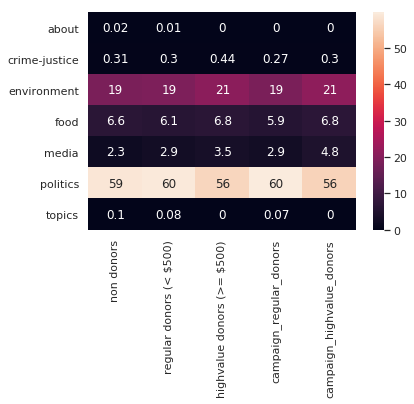

In [36]:
sns.heatmap(combo, annot=True)

## Q3. How long do newsletter subscribers tend to stay subscribed?

Not answerable 

In this question subsribers means subscribers to the newsletter, not the magazine.  We actually don't have data for people unsubscribing to the newsletter, but a more interesting measure is to instead ask when people stop engaging with the newsletter.  E.g. when do we see a dropoff in clicking (in their emails appearing in the emails campaign data).

## Q4. What do our print subscribers engage in vs our online readers in the newsletters?

The newsletter click data ranges from 2018/09/19 to 2018/10/30
The magazine subscription data ranges from 2017-10-01 to 2018-11-09

Limit magazine subscribers to 2017/09/20 - 2018/10/30 to get the overlap between newsletter subscribes and magazine subscribes

In [59]:
# check if `nclicks_by_users` and `nclicks_by_topics` have been defined in cell 2
if 'nclicks_by_users' not in locals():
    nclicks_by_users = click_data.groupby('Email').agg({'Url': pd.Series.nunique,'topic':pd.Series.nunique})
    nclicks_by_users = nclicks_by_users.reset_index()

    nclicks_by_topics = reshape_data_to_wide(click_data,
                                             row = 'Email', 
                                             col = 'topic', 
                                             element = 'Url',
                                             cal = 'sum')
    nclicks_by_topics = nclicks_by_topics.reset_index()
    nclicks_by_topics = nclicks_by_topics.rename(columns = {'':'NA'})
else:
    pass

In [61]:
min_date = datetime.date(2016, 1, 1)
min_date2 = datetime.date(2017, 1, 1)
max_date = datetime.date(2018, 11, 30)

# get all the emails who subscribed the magazine within a year of the click data but before the end date of the click data
mag_sub = subscription[(subscription['ORD ENTR DT'] > min_date) & (subscription['ORD ENTR DT'] < max_date)]['EMAIL'].unique().tolist()
# get all the emails who subscribed the magazine during the newsletter campaign
recent_mag_sub = subscription[(subscription['ORD ENTR DT'] > min_date2) & (subscription['ORD ENTR DT'] < max_date)]['EMAIL'].unique().tolist()
# get all the emails who subscribed the news letter
news_sub = click_data['Email'].unique().tolist()

mag_news_sub_all = combine_dat_sets(nclicks_by_topics, nclicks_by_users, 'Email','Email', join_method = 'left')
mag_news_sub_all['MJM'] = mag_news_sub_all['Email'].isin(mag_sub)

online_reader_groups=OrderedDict()
online_reader_groups['magazine subscribers']=mag_news_sub_all[mag_news_sub_all['MJM'] == True]
online_reader_groups['non-magazine subscribers']=mag_news_sub_all[ mag_news_sub_all['MJM'] == False]
online_reader_groups['recent magazine subscribers']=mag_news_sub_all[(mag_news_sub_all['MJM'] == True) & (mag_news_sub_all['Email'].isin(recent_mag_sub))]

In [63]:
online_reader_groups['magazine subscribers'].shape

(20815, 30)

In [24]:
for t in click_data.topic.unique():
    print(click_data[click_data['topic']==t].Url.head(n=3))

1     http://www.motherjones.com/kevin-drum/2017/03/private-it-turns-out-trump-pretty-much-same
2     http://www.motherjones.com/kevin-drum/2017/03/private-it-turns-out-trump-pretty-much-same
10    http://www.motherjones.com/kevin-drum/2017/03/private-it-turns-out-trump-pretty-much-same
Name: Url, dtype: object
3      http://www.motherjones.com/environment/2017/03/wildfires-rip-through-heart-climate-denier-country
101    http://www.motherjones.com/environment/2017/03/wildfires-rip-through-heart-climate-denier-country
601    http://www.motherjones.com/environment/2017/03/climate-denier-discrimination-bill                
Name: Url, dtype: object
4    http://www.motherjones.com/politics/2017/03/exhaustive-history-donald-trump-russia-scandal-timeline
6    http://www.motherjones.com/politics/2017/03/ivanka-trump-federal-employee-white-house              
7    http://www.motherjones.com/politics/2017/03/trump-obamacare-repeal-promise-so-easy                 
Name: Url, dtype: object
5      

### a. how many online readers have subscribed the magazine?

In [64]:
print('out of {} clicked the newsletter, {} have subscribed magazine within a year ({}%)'.format(
    mag_news_sub_all.shape[0], 
    sum(mag_news_sub_all['MJM']), 
    round(sum(mag_news_sub_all['MJM'])/mag_news_sub_all.shape[0]*100,2)
 ))


out of 224714 clicked the newsletter, 20815 have subscribed magazine within a year (9.26%)


### b. what's the click rate difference between online reasers who subcribed the magazines within a year,  who subscribed the magazines during the newsletter campaign and who didn't subcribe the magazines?

In [65]:
online_reader_groups_click_summary = []

for grpname, dat in online_reader_groups.items():
    
    online_reader_groups_click_summary.append(check_click_distribution(df =dat, groupname =grpname))
    
print("compare # urls clicked by each donor group ")    
display(pd.concat(online_reader_groups_click_summary, axis=1))

online_reader_groups_topics_summary = []

for grpname, dat in online_reader_groups.items():
    
    online_reader_groups_topics_summary.append(check_topics_distribution(df =dat, groupname =grpname))
    
print("compare # topics clicked by each donor group ")    
display(pd.concat(online_reader_groups_topics_summary, axis=1))

compare # urls clicked by each donor group 


,magazine subscribers,non-magazine subscribers,recent magazine subscribers
count,20815.00,203898.00,17877.00
mean,27.63,23.10,28.18
std,65.41,56.99,66.87
min,1.00,1.00,1.00
25%,1.00,2.00,1.00
50%,5.00,6.00,5.00
75%,25.00,20.00,26.00
max,1577.00,2809.00,1577.00


compare # topics clicked by each donor group 


,magazine subscribers,non-magazine subscribers,recent magazine subscribers
count,20815.00,203898.00,17877.00
mean,3.35,3.39,3.36
std,2.44,2.23,2.43
min,1.00,1.00,1.00
25%,1.00,1.00,1.00
50%,3.00,3.00,3.00
75%,5.00,5.00,5.00
max,12.00,17.00,12.00


### c. what's the difference in the interested topics between online reasers who subcribed the magazines within a year, who subscribed the magazines during the newsletter campaign and who didn't subcribe the magazines?

In [66]:
# compare topic click rate
topics = ['about','crime-justice', 'environment', 'food', 'kevin-drum',
       'media', 'mixed-media','politics']
comparison_groups = ['magazine subscribers',
                     'non-magazine subscribers',
                     'recent magazine subscribers'
                    ]
combo = pd.concat([sub_df_colsum(df = online_reader_groups[k],cols = topics, name = k) for k in comparison_groups],axis=1)

# convert to click percentage
for g in comparison_groups:
      combo[g] = round(combo[g]/sum(online_reader_groups[g]['All'])*100,2) 
     
print('compare magazine subscribers, recent magazine subscribers and non subscribers of the topics they clicked')
print('all the numbers are the percentage of urls containing the certain topics')
combo

compare magazine subscribers, recent magazine subscribers and non subscribers of the topics they clicked
all the numbers are the percentage of urls containing the certain topics


,magazine subscribers,non-magazine subscribers,recent magazine subscribers
about,0.21,0.12,0.21
crime-justice,0.65,0.66,0.67
environment,16.09,16.70,16.01
food,4.11,4.34,4.13
kevin-drum,9.38,9.33,9.33
media,4.03,3.59,4.05
mixed-media,0.35,0.49,0.32
politics,48.70,47.61,48.70


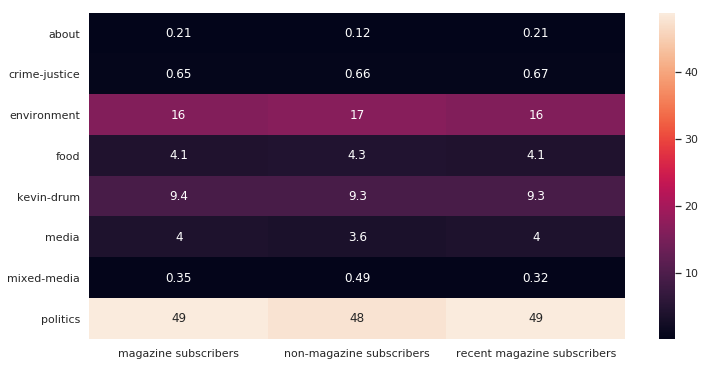

In [38]:
import seaborn as sns; sns.set()
sns.set(rc={'figure.figsize':(12,6)})
sns.heatmap(combo, annot=True)

### d. what's the difference in the most popular titles between online readers who subcribed the magazines within a year, who subscribed the magazines during the newsletter campaign and who didn't subcribe the magazines?

In [67]:
def find_most_popular_titles(df, emails, topN = 10):
    """an example of df is click_data from '/home/centos/mojo/newsletter_processed_data.pkl'"""
    temp_data = df.loc[df['Email'].isin(emails)]
    temp_data = temp_data[temp_data['title']!='']


    hoturls = temp_data.groupby('title').agg({'Email': pd.Series.nunique})
    hoturls = hoturls.reset_index()
    hoturls = hoturls.rename(columns = {'Email':'email_count'})
    hoturls['email_pct'] = round(hoturls['email_count']/len(temp_data['Email'].unique())*100,2)
    topN_urls = hoturls.sort_values(by='email_count', ascending=False).head(topN)
    
    return topN_urls

In [68]:
print("Top 10 clicks from online readers who subcribed the magazines within a year")
find_most_popular_titles(df = click_data, emails = online_reader_groups['magazine subscribers']['Email'])

Top 10 clicks from online readers who subcribed the magazines within a year


,title,email_count,email_pct
2782,trump-nonstop-lies,3003,16.98
2985,vice-president-pence-lawyers-up,2962,16.75
1743,new-yorker-cartoon-hits-at-trumps-fake-time-cover,2791,15.79
1871,paul-ryan-brags-about-giving-public-school-employee-1-50,2717,15.37
3004,watch-trump-shove-nato-leader-get-front-group-photo,2462,13.92
1492,leaked-email-trump-models-will-officially-shut-down,2285,12.92
1014,flynn-trump-washington-post-russia,2173,12.29
797,donald-trump-jr-s-email-scandal-lands-cover-of-time,2158,12.21
3088,why-bmi-big-fat-scam,2114,11.96
2126,sam-brownback-kansas-tax-cuts-donald-trump,2065,11.68


In [69]:
print("Top 10 clicks from online readers who didn't subcribe the magazines")
find_most_popular_titles(df = click_data, emails = online_reader_groups['non-magazine subscribers']['Email'])

Top 10 clicks from online readers who didn't subcribe the magazines


,title,email_count,email_pct
3713,vice-president-pence-lawyers-up,25427,12.84
3469,trump-nonstop-lies,24838,12.54
2356,paul-ryan-brags-about-giving-public-school-employee-1-50,24025,12.13
637,carrie-fisher-donald-trump,23254,11.74
2193,new-yorker-cartoon-hits-at-trumps-fake-time-cover,23121,11.68
3740,watch-trump-shove-nato-leader-get-front-group-photo,22979,11.60
953,donald-trump-climate-white-house-website,21029,10.62
2679,sam-brownback-kansas-tax-cuts-donald-trump,19631,9.91
1869,leaked-email-trump-models-will-officially-shut-down,18999,9.59
1269,flynn-trump-washington-post-russia,18479,9.33


In [70]:
print("Top 10 clicks from online readers who subscribed the magazines during the newsletter campaign")
find_most_popular_titles(df = click_data, emails = online_reader_groups['recent magazine subscribers']['Email'])

Top 10 clicks from online readers who subscribed the magazines during the newsletter campaign


,title,email_count,email_pct
2748,trump-nonstop-lies,2623,17.34
2950,vice-president-pence-lawyers-up,2552,16.87
1722,new-yorker-cartoon-hits-at-trumps-fake-time-cover,2417,15.98
1848,paul-ryan-brags-about-giving-public-school-employee-1-50,2390,15.80
2969,watch-trump-shove-nato-leader-get-front-group-photo,2101,13.89
1474,leaked-email-trump-models-will-officially-shut-down,1949,12.89
788,donald-trump-jr-s-email-scandal-lands-cover-of-time,1863,12.32
3052,why-bmi-big-fat-scam,1852,12.24
1000,flynn-trump-washington-post-russia,1838,12.15
648,creeping-authoritarianism-trump-trumpocracy,1805,11.93


## Q5.  What differences and similarities can we find between loyal subscribers and new donors?

Assume: 
- loyal subscribers are people who subscribed magazines two years in a row (assume people renew within a month before the subscription expires)
- new donors are people who first donated during the campaigns.

### a.how many loyal subscribers and new donors clicked newsletter? how much did they donate?

In [45]:
loyal_sub = sub_don_click_combined[sub_don_click_combined['subs_range'] > 365-60]

# donors from the month
min_date = datetime.date(2017, 1, 1)
max_date = datetime.date(2018, 11, 30)
old_donors_emails = donation[donation['ORD ENTR DT'] < min_date]['EMAIL'].unique().tolist()
new_donors_emails = donation['EMAIL'][~donation['EMAIL'].isin(old_donors_emails)]

new_donors = sub_don_click_combined[sub_don_click_combined.index.isin(new_donors_emails)]

interested_groups=OrderedDict()
interested_groups['loyal subscribers'] = loyal_sub
interested_groups['new donors'] = new_donors

In [46]:
print("{} % loyal subscribers clicked and {}% donated ${} on average per person".format(
    round(100*((interested_groups['loyal subscribers']['Url'] > 0).mean()),2),
    round(100*((interested_groups['loyal subscribers']['don_freq'] > 0).mean()),2),
    round(interested_groups['loyal subscribers'][interested_groups['loyal subscribers']['don_freq'] > 0]['don_total'].mean(),2)))

32.55 % loyal subscribers clicked and 34.35% donated $153.67 on average per person


In [47]:
print("{} % new donors clicked and donated ${} on average per person".format(
    round(100*((interested_groups['new donors']['Url'] > 0).mean()),2),
    round(interested_groups['new donors']['don_total'].mean(),2)))

30.5 % new donors clicked and donated $70.94 on average per person


In [ ]:
## click rate comparison
## topic comparison
## topic article comparison

### b. compare the number of urls clicked by loyal subscribers and new donors 

In [48]:
interested_groups_click_summary = []

for grpname, dat in interested_groups.items():
    
    interested_groups_click_summary.append(check_click_distribution(df =dat, groupname =grpname))
    
print("compare # urls clicked by loyal subscribers vs new donors ")    
display(pd.concat(interested_groups_click_summary, axis=1))

interested_groups_topics_summary = []

for grpname, dat in interested_groups.items():
    
    interested_groups_topics_summary.append(check_topics_distribution(df =dat, groupname =grpname))
    
print("compare # topics clicked by loyal subscribers vs new donors")    
display(pd.concat(interested_groups_topics_summary, axis=1))

compare # urls clicked by loyal subscribers vs new donors 


,loyal subscribers,new donors
count,9721.00,11831.00
mean,28.33,40.97
std,68.35,76.10
min,1.00,1.00
25%,1.00,2.00
50%,4.00,11.00
75%,24.00,46.00
max,1240.00,1227.00


compare # topics clicked by loyal subscribers vs new donors


,loyal subscribers,new donors
count,9721.00,11831.00
mean,3.26,4.00
std,2.47,2.54
min,1.00,1.00
25%,1.00,1.00
50%,2.00,4.00
75%,5.00,6.00
max,11.00,12.00


### c. compare the topics clicked by loyal subscribers and new donors

In [49]:
topics = ['about','crime-justice', 'environment', 'food', 'kevin-drum',
       'media', 'mixed-media','politics']
comparison_groups = ['loyal subscribers','new donors']
combo = pd.concat([sub_df_colsum(df = interested_groups[k],cols = topics, name = k) for k in comparison_groups],axis=1)

# convert to click percentage
for g in comparison_groups:
      combo[g] = round(combo[g]/sum(interested_groups[g]['All'])*100,2) 

combo

,loyal subscribers,new donors
about,0.22,0.17
crime-justice,0.64,0.68
environment,16.17,16.58
food,3.95,4.39
kevin-drum,9.58,9.07
media,4.09,3.79
mixed-media,0.34,0.31
politics,48.93,48.86


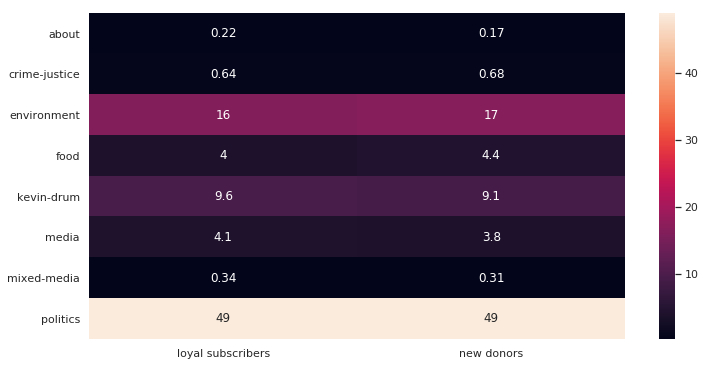

In [50]:
sns.heatmap(combo, annot=True)

In [51]:
print("Top 10 clicks from loyal subscribers")
find_most_popular_titles(df = click_data, emails = interested_groups['loyal subscribers'].index)

Top 10 clicks from loyal subscribers


,title,email_count,email_pct
2551,trump-nonstop-lies,1443,18.16
2746,vice-president-pence-lawyers-up,1378,17.34
1579,new-yorker-cartoon-hits-at-trumps-fake-time-cover,1322,16.64
1697,paul-ryan-brags-about-giving-public-school-employee-1-50,1257,15.82
2763,watch-trump-shove-nato-leader-get-front-group-photo,1172,14.75
1354,leaked-email-trump-models-will-officially-shut-down,1099,13.83
733,donald-trump-jr-s-email-scandal-lands-cover-of-time,1022,12.86
2840,why-bmi-big-fat-scam,1006,12.66
600,creeping-authoritarianism-trump-trumpocracy,996,12.53
1940,sam-brownback-kansas-tax-cuts-donald-trump,994,12.51


In [52]:
print("Top 10 clicks from new donors")
find_most_popular_titles(df = click_data, emails = interested_groups['new donors'].index)

Top 10 clicks from new donors


,title,email_count,email_pct
2668,trump-nonstop-lies,2438,22.10
1781,paul-ryan-brags-about-giving-public-school-employee-1-50,2179,19.75
2870,vice-president-pence-lawyers-up,2166,19.63
1660,new-yorker-cartoon-hits-at-trumps-fake-time-cover,1985,17.99
2889,watch-trump-shove-nato-leader-get-front-group-photo,1923,17.43
2966,why-bmi-big-fat-scam,1803,16.34
1418,leaked-email-trump-models-will-officially-shut-down,1691,15.33
2906,wells-fargo-accidentally-admits-the-truth-the-republican-tax-bill-has-no-connection-to-its-15-minimum-wage,1689,15.31
758,donald-trump-jr-s-email-scandal-lands-cover-of-time,1597,14.48
624,creeping-authoritarianism-trump-trumpocracy,1566,14.20


## Q6. Which behaviors are most likely to lead to subscription or donation?
only have oct campaign data. too little to analyze the factors that lead to donation or subscription

## Presentation summary
- donation:
    - regular donor
    - high-value donor
    - non donor
- subscription
    - print only
    - online only
    - both
    
- compare the six groups:
    - % print sub
    - % online click
    - avg urls
    - avg topics
    - avg donation
    - topic index vs avg online reader
    - top 10 articles vs avg online reader

In [45]:
nclicks_by_users = click_data.groupby('Email').agg({'Url': pd.Series.nunique,'topic':pd.Series.nunique})
nclicks_by_users = nclicks_by_users.reset_index()

nclicks_by_topics = reshape_data_to_wide(click_data,
                                         row = 'Email', 
                                         col = 'topic', 
                                         element = 'Url',
                                         cal = 'sum')
nclicks_by_topics = nclicks_by_topics.reset_index()
nclicks_by_topics = nclicks_by_topics.rename(columns = {'':'NA'})

sub_don_click_combined_temp = combine_dat_sets(combined, 
                                               nclicks_by_users, 
                                               'Email','Email', join_method = 'outer')
all_dat = combine_dat_sets(sub_don_click_combined_temp, 
                            nclicks_by_topics,
                             'Email','Email', join_method = 'outer')
all_dat = all_dat.set_index('Email')

In [49]:
def define_interested_groups(df):    
    
    """Take donation data and dive donors into different groups and save data in an ordered dictionary
    
    example 'df' is:
    sub_don_click_combined_filename = '/home/centos/mojo/subscription_donation_click_combined_data.pkl'
    df = pd.read_pickle(sub_don_click_combined_filename)
    """
    
    
    highvalue_donors = df.loc[df['don_total'] >= 500]
    regular_donors = df.loc[(df['don_total'] > 0) & (df['don_total'] < 500)]
    non_donors = df.loc[df['don_total'] == 0]
    
    sub_print_only = df.loc[(df['subs_freq'] >0) & (df['Url'] == 0)]
    sub_online_only = df.loc[(df['subs_freq'] == 0) & (df['Url'] > 0)]
    sub_both = df.loc[(df['subs_freq'] >0) & (df['Url']>0)]
    sub_all_online = df.loc[(df['Url']>0)]
    
    interested_groups=OrderedDict()
    interested_groups['regular donors (< $500)']=regular_donors
    interested_groups['highvalue donors (>= $500)']=highvalue_donors
    interested_groups['non donors']=non_donors
    interested_groups['print subscriber only'] = sub_print_only
    interested_groups['online reader only'] = sub_online_only 
    interested_groups['both print subscriber and online reader'] = sub_both
    interested_groups['all online readers'] = sub_all_online
    return interested_groups

In [50]:
interested_groups = define_interested_groups(df= all_dat)

### compare magazine subscription rate and newsletter click rate by each donor group 

In [51]:
# subscription rate summary
subscription_rate_summary = []

for grpname, dat in interested_groups.items():
    
    subscription_rate_summary.append(check_subscription_rate(df =dat, groupname =grpname))
    
subscription_rate_summary

subscription_rate_summary_df = pd.DataFrame.from_records(subscription_rate_summary)
subscription_rate_summary_df = subscription_rate_summary_df.rename(columns = {0:'group name',
                                                                    1: 'magazine subscription rate',
                                                                    2: 'newsletter click rate'})

print("compare magazine subscription rate and newsletter click rate by each donor group ")   
subscription_rate_summary_df

compare magazine subscription rate and newsletter click rate by each donor group 


,group name,magazine subscription rate,newsletter click rate
0,regular donors (< $500),32.11,33.46
1,highvalue donors (>= $500),32.76,44.32
2,non donors,23.71,81.36
3,print subscriber only,100.00,0.00
4,online reader only,0.00,100.00
5,both print subscriber and online reader,100.00,100.00
6,all online readers,9.39,100.00


### compare avg number of clicks by each donor group

In [52]:
click_summary = []

for grpname, dat in interested_groups.items():
    
    click_summary.append(check_click_distribution(df =dat, groupname =grpname))
    
print("compare # urls clicked by each donor group ")    
pd.concat(click_summary, axis=1)


compare # urls clicked by each donor group 


,regular donors (< $500),highvalue donors (>= $500),non donors,print subscriber only,online reader only,both print subscriber and online reader,all online readers
count,22430.00,1135.00,201148.00,0.0,203615.00,21098.00,224713.00
mean,42.62,48.70,21.25,NaN,23.09,27.70,23.52
std,82.80,95.61,53.59,NaN,57.00,65.28,57.84
min,1.00,1.00,1.00,NaN,1.00,1.00,1.00
25%,2.00,1.50,2.00,NaN,2.00,1.00,2.00
50%,10.00,7.00,5.00,NaN,6.00,5.00,6.00
75%,47.00,54.00,18.00,NaN,20.00,25.00,20.00
max,1856.00,1422.00,2809.00,NaN,2809.00,1577.00,2809.00


### compare avg number of topics by each donor group

In [53]:
topics_summary = []

for grpname, dat in interested_groups.items():
    
    topics_summary.append(check_topics_distribution(df =dat, groupname =grpname))
    
print("compare # topics clicked by each donor group ")    
display(pd.concat(topics_summary, axis=1))

compare # topics clicked by each donor group 


,regular donors (< $500),highvalue donors (>= $500),non donors,print subscriber only,online reader only,both print subscriber and online reader,all online readers
count,22430.00,1135.00,201148.00,0.0,203615.00,21098.00,224713.00
mean,3.99,3.92,3.32,NaN,3.39,3.35,3.39
std,2.62,2.76,2.19,NaN,2.23,2.44,2.25
min,1.00,1.00,1.00,NaN,1.00,1.00,1.00
25%,1.00,1.00,1.00,NaN,1.00,1.00,1.00
50%,4.00,3.00,3.00,NaN,3.00,3.00,3.00
75%,6.00,6.00,5.00,NaN,5.00,5.00,5.00
max,13.00,11.00,17.00,NaN,17.00,12.00,17.00


### compare avg donation by each donor group

In [54]:
def check_avg_donor_rate(df, groupname):
    
    if sum(df['don_total']>0) >0:
        avg_don = round(df['don_total'][df['don_total']>0].median(),2)
    else:
        avg_don = 0
    return (groupname, avg_don)
                    
avg_donation_summary = []

for grpname, dat in interested_groups.items():
    
    avg_donation_summary.append(check_avg_donor_rate(df =dat, groupname =grpname))

avg_donor_summary_df = pd.DataFrame.from_records(avg_donation_summary)
avg_donor_summary_df = avg_donor_summary_df.rename(columns = {0:'group name',
                                                                    1: 'avg donation'})

print("compare average donation amounts by each donor group ")   
avg_donor_summary_df

compare average donation amounts by each donor group 


,group name,avg donation
0,regular donors (< $500),50.0
1,highvalue donors (>= $500),675.0
2,non donors,0.0
3,print subscriber only,50.0
4,online reader only,50.0
5,both print subscriber and online reader,65.0
6,all online readers,50.0


### compare topic click rate and index by each donor group

In [55]:
topics = ['about','crime-justice', 'environment', 'food', 'kevin-drum',
       'media', 'mixed-media','politics']
comparison_groups = interested_groups.keys()
combo = pd.concat([sub_df_colsum(df = interested_groups[k],cols = topics, name = k) for k in comparison_groups],axis=1)

# convert to click percentage
for g in comparison_groups:
      combo[g] = round(combo[g]/sum(interested_groups[g]['All'])*100,2) 

# how much likely the group is to click a topic than average
combo_index = combo.copy()
for c in combo_index.columns:
    combo_index[c] = round((combo_index[c]/combo['all online readers'] - 1)*100,2)

combo_index = combo_index.drop(columns=['print subscriber only','all online readers'])
combo = combo.drop(columns=['print subscriber only'])

In [58]:
combo_index.columns

Index(['regular donors (< $500)', 'highvalue donors (>= $500)', 'non donors',
       'print subscriber only', 'online reader only',
       'both print subscriber and online reader', 'all online readers'],
      dtype='object')

[Text(0,0.5,'about'),
 Text(0,1.5,'crime-justice'),
 Text(0,2.5,'environment'),
 Text(0,3.5,'food'),
 Text(0,4.5,'kevin-drum'),
 Text(0,5.5,'media'),
 Text(0,6.5,'mixed-media'),
 Text(0,7.5,'politics')]

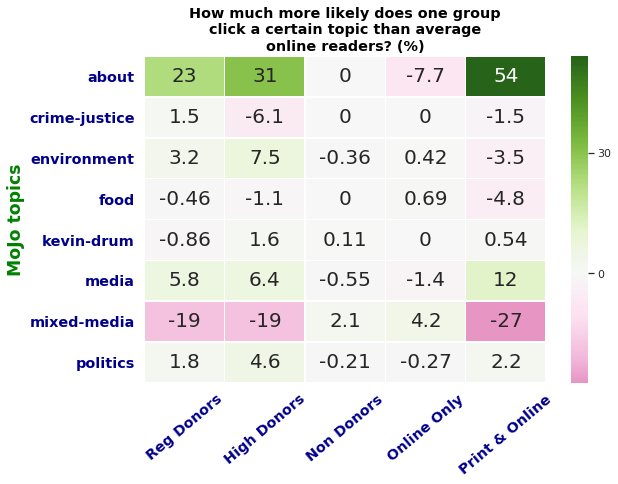

In [56]:
import seaborn as sns; sns.set()


sns.set(rc={'figure.figsize':(9,6)})
hm = sns.heatmap(combo_index.iloc[:,:6], 
                 annot=True,
                 annot_kws = {'size':20},
                 cmap="PiYG",center = 0,
                 linewidths=.5,
                 cbar_kws = {'ticks':[0,30,60]})
                 

hm.set_title("\n".join(wrap('How much more likely does one group click a certain topic than average online readers? (%)',40)),
             fontsize = 'large', color = 'black',fontweight = 'bold')
hm.set_ylabel('MoJo topics', fontsize = 'x-large', color = 'green',fontweight = 'bold')
hm.set_xticklabels(['Reg Donors','High Donors','Non Donors','Online Only','Print & Online'], 
                   rotation=40,fontweight = 'bold',fontsize = 'large', color = 'darkblue')
hm.set_yticklabels(combo.index, fontweight = 'bold',fontsize = 'large', color = 'darkblue')


[Text(0,0.5,'about'),
 Text(0,1.5,'crime-justice'),
 Text(0,2.5,'environment'),
 Text(0,3.5,'food'),
 Text(0,4.5,'kevin-drum'),
 Text(0,5.5,'media'),
 Text(0,6.5,'mixed-media'),
 Text(0,7.5,'politics')]

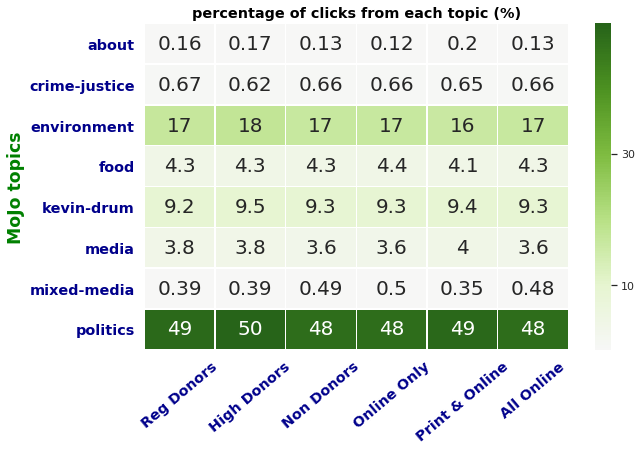

In [57]:
import seaborn as sns; sns.set()

sns.set(rc={'figure.figsize':(9.5,6)})
hm = sns.heatmap(combo, 
                 annot=True,
                 annot_kws = {'size':20},
                 cmap="PiYG",center = 0,linewidths=.5,
                 cbar_kws = {'ticks':[10,30,50]})
                 

hm.set_title("\n".join(wrap('percentage of clicks from each topic (%)',40)),
             fontsize = 'large', color = 'black',fontweight = 'bold')
hm.set_ylabel('MoJo topics', fontsize = 'x-large', color = 'green',fontweight = 'bold')
hm.set_xticklabels(['Reg Donors','High Donors','Non Donors','Online Only','Print & Online','All Online'], 
                   rotation=40,fontweight = 'bold',fontsize = 'large', color = 'darkblue')
hm.set_yticklabels(combo.index, fontweight = 'bold',fontsize = 'large', color = 'darkblue')


[Text(0.5,0,'regular donors (< $500)'),
 Text(1.5,0,'highvalue donors (>= $500)'),
 Text(2.5,0,'non donors'),
 Text(3.5,0,'online reader only'),
 Text(4.5,0,'both print subscriber and online reader'),
 Text(5.5,0,'all online readers')]

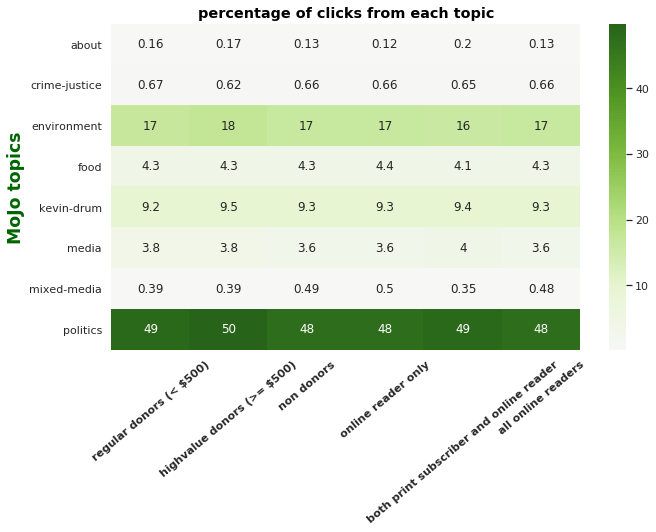

In [67]:
import seaborn as sns; 
sns.set(rc={'figure.figsize':(10.5,6)})
hm = sns.heatmap(combo, annot=True,cmap="PiYG", center = 0)
hm.set_title("\n".join(wrap('percentage of clicks from each topic (%)',40)),
             fontsize = 'large', color = 'black',fontweight = 'bold')
hm.set_title('percentage of clicks from each topic',fontsize = 'large', color = 'black',fontweight = 'bold')
hm.set_ylabel('MoJo topics',fontsize = 'x-large', color = 'darkgreen',fontweight = 'bold')
hm.set_xticklabels(combo.columns, rotation=40,fontweight = 'bold')

### compare top clicks 

In [58]:
print("Top 10 clicks from loyal subscribers")
for k in interested_groups.keys():
    print(' #### {}'.format(k))
    display(find_most_popular_titles(df = click_data, emails = interested_groups[k].index)[['title','email_pct']])

Top 10 clicks from loyal subscribers
 #### regular donors (< $500)


,title,email_pct
2947,trump-nonstop-lies,0.224073
3167,vice-president-pence-lawyers-up,0.199165
3187,watch-trump-shove-nato-leader-get-front-group-photo,0.186975
1839,new-yorker-cartoon-hits-at-trumps-fake-time-cover,0.185823
1978,paul-ryan-brags-about-giving-public-school-employee-1-50,0.183712
540,carrie-fisher-donald-trump,0.177185
3274,why-bmi-big-fat-scam,0.166819
1567,leaked-email-trump-models-will-officially-shut-down,0.163267
2254,sam-brownback-kansas-tax-cuts-donald-trump,0.160388
805,donald-trump-climate-white-house-website,0.159908


 #### highvalue donors (>= $500)


,title,email_pct
2102,trump-nonstop-lies,0.244141
2347,why-bmi-big-fat-scam,0.207031
2287,watch-trump-shove-nato-leader-get-front-group-photo,0.207031
374,carrie-fisher-donald-trump,0.205078
2273,vice-president-pence-lawyers-up,0.199219
1588,sam-brownback-kansas-tax-cuts-donald-trump,0.192383
1294,new-yorker-cartoon-hits-at-trumps-fake-time-cover,0.185547
1395,paul-ryan-brags-about-giving-public-school-employee-1-50,0.182617
2288,watch-young-girl-invite-republican-congressman-her-science-class,0.179688
2076,trump-job-approval-already-sinking-before-comey-testimony,0.176758


 #### non donors


,title,email_pct
3669,vice-president-pence-lawyers-up,0.123998
3431,trump-nonstop-lies,0.118256
2329,paul-ryan-brags-about-giving-public-school-employee-1-50,0.117250
2170,new-yorker-cartoon-hits-at-trumps-fake-time-cover,0.112725
636,carrie-fisher-donald-trump,0.110115
3695,watch-trump-shove-nato-leader-get-front-group-photo,0.110058
949,donald-trump-climate-white-house-website,0.100209
2648,sam-brownback-kansas-tax-cuts-donald-trump,0.093673
1851,leaked-email-trump-models-will-officially-shut-down,0.091341
1262,flynn-trump-washington-post-russia,0.089009


 #### print subscriber only


,title,email_pct


 #### online reader only


,title,email_pct
3713,vice-president-pence-lawyers-up,0.128313
3469,trump-nonstop-lies,0.125360
2356,paul-ryan-brags-about-giving-public-school-employee-1-50,0.121279
637,carrie-fisher-donald-trump,0.117430
2193,new-yorker-cartoon-hits-at-trumps-fake-time-cover,0.116682
3740,watch-trump-shove-nato-leader-get-front-group-photo,0.116009
953,donald-trump-climate-white-house-website,0.106224
2679,sam-brownback-kansas-tax-cuts-donald-trump,0.099149
1869,leaked-email-trump-models-will-officially-shut-down,0.095902
1269,flynn-trump-washington-post-russia,0.093348


 #### both print subscriber and online reader


,title,email_pct
2786,trump-nonstop-lies,0.170009
2989,vice-president-pence-lawyers-up,0.168004
1744,new-yorker-cartoon-hits-at-trumps-fake-time-cover,0.158144
1873,paul-ryan-brags-about-giving-public-school-employee-1-50,0.153743
3008,watch-trump-shove-nato-leader-get-front-group-photo,0.139316
1493,leaked-email-trump-models-will-officially-shut-down,0.129234
1014,flynn-trump-washington-post-russia,0.122159
797,donald-trump-jr-s-email-scandal-lands-cover-of-time,0.121881
3092,why-bmi-big-fat-scam,0.119931
653,creeping-authoritarianism-trump-trumpocracy,0.117090


 #### all online readers


,title,email_pct
3737,vice-president-pence-lawyers-up,0.131616
3492,trump-nonstop-lies,0.129076
2372,paul-ryan-brags-about-giving-public-school-employee-1-50,0.123981
2206,new-yorker-cartoon-hits-at-trumps-fake-time-cover,0.120133
3764,watch-trump-shove-nato-leader-get-front-group-photo,0.117949
641,carrie-fisher-donald-trump,0.117045
959,donald-trump-climate-white-house-website,0.106335
2700,sam-brownback-kansas-tax-cuts-donald-trump,0.100586
1880,leaked-email-trump-models-will-officially-shut-down,0.098676
1277,flynn-trump-washington-post-russia,0.095746
